## UGCA Group Assignment -2 

# Group Members
1. Chetna Singhal (cs57926)
2. David Kinman
3. Prajval Gupta
4. Subhayu Chakravarty
5. Whitt Hyde

### PART A - Collecting tweets using Tweepy

In [1]:
import os
#import tweepy as tw
import pandas as pd
import datetime
from string import punctuation
from bs4 import BeautifulSoup
import re
import nltk
from time import sleep
import copy
import matplotlib.pyplot as plt
import numpy as np
from itertools import groupby
from collections import Counter
from nltk import ngrams, FreqDist
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, webtext
from sklearn import manifold
import nltk.data
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sentiment
from textblob import TextBlob
%pylab inline


Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
with open('secrets.txt', 'r') as file:
    data = file.read().split('\n')
    
consumer_key = data[0]
consumer_secret = data[1]
access_key = data[2]
access_secret = data[3]

FileNotFoundError: [Errno 2] No such file or directory: 'secrets.txt'

In [ ]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tw.API(auth,wait_on_rate_limit=True,
    wait_on_rate_limit_notify=True)

In [ ]:
try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

In [ ]:
def get_query_tweets(query, num=0):
    num = 3000 if num > 3000 else num
    max_num_per_call = 100

    #authorize twitter, initialize tweepy
    auth = tw.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tw.API(auth)
    
    #initialize a list to hold all the tweepy Tweets
    alltweets = []    
    
    #make initial request for most recent tweets (200 is the maximum allowed count)
    curr_count = max_num_per_call if num > max_num_per_call else num
    num -= curr_count

    new_tweets = api.search(q=query, count=curr_count)
    
    #save most recent tweets
    alltweets.extend(new_tweets)
    
    #save the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1
    
    print(f"{len(alltweets)} tweets downloaded so far")

    #keep grabbing tweets until there are no tweets left to grab
    while num > 0:
        print(f"Getting tweets before {oldest}")
        
        curr_count = max_num_per_call if num > max_num_per_call else num

        #all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = api.search(q=query, count=curr_count, max_id=oldest)
        num -= curr_count
        
        #save most recent tweets
        alltweets.extend(new_tweets)
        
        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1
        
        print(f"{len(alltweets)} tweets downloaded so far")
    
    #transform the tweepy tweets into a 2D array that will populate the csv    
    outtweets = [[tweet.id_str, tweet.created_at, tweet.text.encode("utf-8"), tweet.user.location] for tweet in alltweets]
    df = pd.DataFrame(outtweets, columns=["id", "created_at", "text", "location"])
    #df.to_csv(f"query_{query}.csv", index=False)
    #print(df.head())
    return df

In [ ]:
# pass in the search query
new_search = "#2020Election" + " -filter:retweets"
tweets1 = get_query_tweets(new_search, 2000)

In [ ]:
# pass in the search query
tweets2 = get_query_tweets("2020 U.S. election", 1000)

In [ ]:
# pass in the search query
tweets3 = get_query_tweets("2020 presidential election", 1000)

In [ ]:
# pass in the search query
new_search = "#election2020" + " -filter:retweets"
tweets4 = get_query_tweets(new_search, 2000)

In [ ]:
print(tweets1.shape,tweets2.shape,tweets3.shape,tweets4.shape)

In [ ]:
tweets=tweets1.append(tweets2, ignore_index=True)

In [ ]:
tweets=tweets.append(tweets3, ignore_index=True)

In [ ]:
tweets=tweets.append(tweets4, ignore_index=True)

In [ ]:
tweets.shape

In [ ]:
tweets.to_csv(r"tweets.csv",index=False)

### Data Cleaning

In [3]:
# Remove all punctuation characters from each tweet and convert text to lowercase for efficient frequency counting
# punctuation includes !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~

def remove_punctuations(item):
    for p in punctuation:
        item = item.strip().replace(p,'')
    return item

# Function to remove stopwords
def remove_stopwords(s):
    return [w for w in s if not w in stop_words] 

In [4]:
# Load user comments into a dataframe
df = pd.read_csv("tweets.csv", usecols=["text"])
df.columns = ["Tweets"]

# Remove newline from each post & drop rows with null values
df = df.replace('\n','', regex=True)
df = df.dropna()

df["Tweet Length"]= df["Tweets"].str.len() 
df.head()

,Tweets,Tweet Length
0,b'No reparations no vote! No BLACK agenda no V...,72
1,b'Thoughts? San Francisco :: Adam Hattersley...,153
2,b'@TheJuanWilliams Why why why are you here???...,85
3,b'#BernieSanders = #Socialism which leads to #...,155
4,b'@AOC should re-think her endorsement of inde...,154


In [5]:
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))
def tweet_cleaner1(text):
    
    # HTML Decoding
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    souped = souped.replace("b", "", 1)
    # Remove URL links
    stripped = re.sub(pat2, '', souped)
    
    # UTF-8 BOM Decoding
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    
    # Remove hastags and numbers
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

In [6]:
clean_tweets = []

for i in range(df.shape[0]):
    clean_tweets.append(tweet_cleaner1(df['Tweets'][i]))
    
clean_tweets = pd.DataFrame(clean_tweets)
clean_tweets.columns = ["Tweets"]

In [7]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/whitthyde/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
clean_tweets["Tweets"] = clean_tweets['Tweets'].apply(remove_punctuations)

# Download stopwords
stop_words = set(stopwords.words('english'))

# Replace the typing errors and combine politician names mentioned differently
clean_tweets['Tweets'].replace({'realdonaldtrump':'trump', 'donaldtrump':'trump', 'donald':'trump', 'trumpxe':'trump', 'trumps':'trump', 'ntrump':'trump'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'elections':'election'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'presidential': 'president'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'democraticdebates':'demdebate','democraticdebate':'demdebate', 'demdebatemnthe ':'demdebate', 'cnndebate':'demdebate', 'demdebates':'demdebate','debates':'demdebate',' debate ': 'demdebate',}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'democratic ': 'democrats',  'thedemocrats ':'democrats', ' democrat ':'democrats', ' dem ':'democrats',}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'ewarren': 'warren',' elizabeth ': 'warren','elizabethwarren': 'warren','senwarren': 'warren' }, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'joebiden': 'biden',' joe ': 'biden'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({' bernie ': 'sanders','berniesanders': 'sanders', 'bernieyellsforus': 'sanders','stillsanders':'sanders'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'petebuttigieg': 'buttigieg',' pete ': 'buttigieg'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'andrewyang': 'yang',' andrew ': 'yang','yanggang': 'yang'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'kamalaharris': 'harris',' kamala ': 'harris'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'jobs':'job','factory':'job'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({' health ':'healthcare'}, inplace=True, regex=True)
clean_tweets['Tweets'].replace({'russian':'russia'}, inplace=True, regex=True)

# Tokenize the posts
df['Tokens'] = clean_tweets['Tweets'].apply(word_tokenize).apply(set).apply(list)
df['Tokens'] = df['Tokens'].apply(remove_stopwords)
df.head()

,Tweets,Tweet Length,Tokens
0,b'No reparations no vote! No BLACK agenda no V...,72,"[black, vote, reparations, agenda, election, a..."
1,b'Thoughts? San Francisco :: Adam Hattersley...,153,"[xa, adam, francisco, alancohn, six, rakes, x,..."
2,b'@TheJuanWilliams Why why why are you here???...,85,"[way, trump, election, thejuanwilliams]"
3,b'#BernieSanders = #Socialism which leads to #...,155,"[socialism, dependency, xa, sanders, governmen..."
4,b'@AOC should re-think her endorsement of inde...,154,"[sanders, lift, independent, aoc, xa, x, ru, r..."


### PART B - Identifying 4 key issues mentioned in the tweets

In [9]:
count = []
# Count the frequency of the words
for i in range(len(df["Tokens"])):
    count += df.iloc[i]['Tokens']
count = [x.lower() for x in count]
word_freq = nltk.FreqDist(count)

# 500 most frequent words
top_words = word_freq.most_common(500)
top_words

[('x', 4391),
 ('xe', 4285),
 ('xa', 4160),
 ('election', 2759),
 ('trump', 1155),
 ('n', 987),
 ('president', 872),
 ('u', 835),
 ('demdebate', 785),
 ('rt', 691),
 ('warren', 450),
 ('biden', 330),
 ('new', 295),
 ('f', 290),
 ('china', 273),
 ('via', 264),
 ('th', 252),
 ('war', 250),
 ('trade', 250),
 ('russia', 248),
 ('xf', 246),
 ('made', 244),
 ('democrats', 235),
 ('making', 234),
 ('months', 231),
 ('washington', 229),
 ('yang', 226),
 ('progress', 224),
 ('headlines', 221),
 ('polic', 220),
 ('tonight', 207),
 ('good', 195),
 ('report', 190),
 ('win', 189),
 ('candidates', 188),
 ('vote', 184),
 ('sanders', 180),
 ('secret', 178),
 ('people', 176),
 ('one', 175),
 ('know', 169),
 ('weapon', 169),
 ('buttigieg', 168),
 ('revealed', 168),
 ('cyberwarfare', 162),
 ('like', 159),
 ('look', 158),
 ('cnn', 150),
 ('get', 148),
 ('think', 141),
 ('would', 141),
 ('candidate', 138),
 ('us', 137),
 ('need', 137),
 ('looks', 136),
 ('many', 129),
 ('maga', 127),
 ('amyklobuchar', 127)

### Analysis
Top Republican candidate - Donald Trump <br>
Top Democratic candidate - Elizabeth Warren <br><br>
Top 6 issues found:
1. China
2. Trade war
3. Russia
4. Cyberwarfare
5. MAGA
6. Job

### C.	Perform lift and sentiment analysis on a candidate and an issue:
To isolate a candidate and an issue, you have to write a parser that selects tweets that mention a candidate, takes a window around an issue, and chops off everything else, as shown in class.  


In [10]:
top_candidiate_count = []

unique_candidates = ['trump','biden']

for (key, items) in top_words:
    if key in unique_candidates:
        candidate_count = (key,items)
        top_candidiate_count.append(candidate_count)  

print ('Candidates we are exploring: \n' , top_candidiate_count[:10])

Top 10 brands along with their frequencies are: 
 [('trump', 1155), ('biden', 330)]


In [11]:
def brand_attri_count(brandList, df_a, attributeList):
    comb_count=[]
    car_count={}
    attrib_count={}
    for car in brandList:
        num_car=0
        for comment in df_a.Tweets:
                if car in comment:
                    num_car+=1
        car_count[car]=num_car
        for attrib in attributeList:
            num_combined=0
            num_attrib=0
            for comment in df_a.Tweets:
                if car in comment and attrib in comment:
                    num_combined+=1
                if attrib in comment:
                    num_attrib+=1
            attrib_count[attrib]=num_attrib
            comb_count.append(((car,attrib),num_combined))
    return [[car_count,attrib_count,comb_count]]

def calculate_lift(car, attrib, combined,attrib_count,car_count):
    if(attrib_count[attrib]==0):
        print(attrib)
    if(car_count[car]==0):
        print(car)
    lift = (5164*combined)/(car_count[car]*attrib_count[attrib])
    return lift

In [13]:
candList = ['trump','biden']
attributeList = ['china','trade','russia','cyberwarfare','job']

# Lift scores for top 5 brands
lift_scores={}
for i in brand_attri_count(candList, df, attributeList):
    for k,num in i[2]:
        lift_scores[(k[0],k[1])] = calculate_lift(k[0],k[1], num,i[1],i[0])
sorted_lifts = sorted(lift_scores.items(), key=lambda kv: kv[1], reverse=True)
print("The sorted Lift scores for top 5 issues are: %s" % sorted_lifts)

The sorted Lift scores for top 5 issues are: [(('trump', 'russia'), 17.445945945945947), (('trump', 'trade'), 0.29320917556211673), (('trump', 'china'), 0.0), (('trump', 'cyberwarfare'), 0.0), (('trump', 'job'), 0.0), (('biden', 'china'), 0.0), (('biden', 'trade'), 0.0), (('biden', 'russia'), 0.0), (('biden', 'cyberwarfare'), 0.0), (('biden', 'job'), 0.0)]


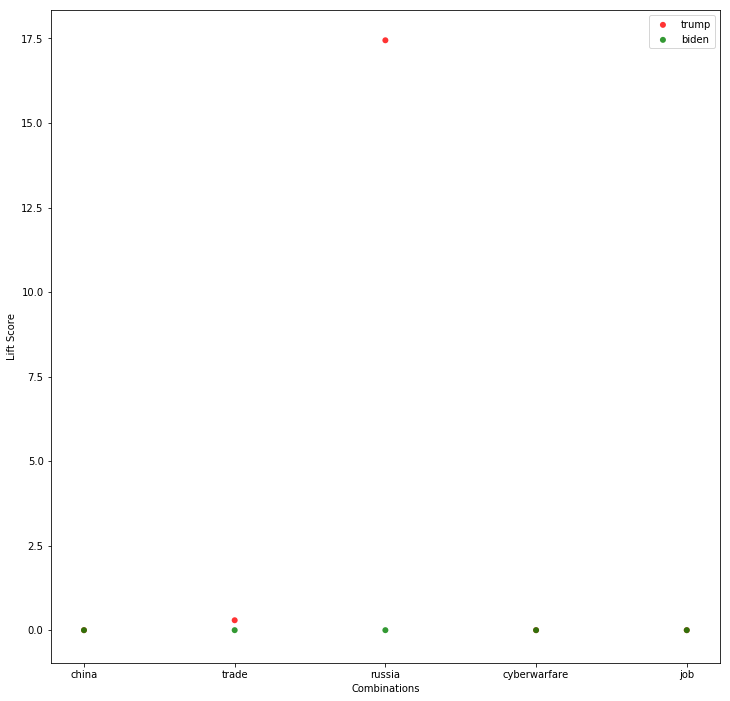

In [14]:
# Plotting dicts for the MDS map
plotarr={}
for b in candList:
    plotarr[b]=[]
for i in lift_scores:
    plotarr[i[0]].append(lift_scores[i])

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
colors = ("red", "green", "blue","black","orange")
groups = plotarr.keys()

for lift, color, group in zip(plotarr, colors, groups):
#     plt.scatter(attributeList,plotarr[lift])
#     ax.scatter(attributeList, plotarr[lift])
    ax.scatter(attributeList, plotarr[lift], alpha=0.8, c=color, edgecolors='none', label=group)

plt.xlabel('Combinations')
plt.ylabel('Lift Score')
plt.legend(loc=1)
plt.show()

Sentiment

In [80]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/whitthyde/nltk_data...


True

In [83]:
def sentiment_value(tweet):
    analyser = sentiment()
    result = analyser.polarity_scores(tweet)
    score = result['compound']
    return round(score,1)

time_line=[]
for i in df['Tweets']:
    
    print(i,'-',sentiment_value(i))


b'No reparations no vote! No BLACK agenda no VOTe! #ADOS  #2020Election' - -0.7
b'Thoughts? San Francisco ::   Adam Hattersley rakes in six\xe2\x80\xa6 https://t.co/MnGzFOYiiQ #2020election #AdamHattersley #AlanCohn #campaignfinance' - 0.0
b'@TheJuanWilliams Why why why are you here???????   #2020Election Trump all the way' - 0.0
b'#BernieSanders = #Socialism which leads to #government dependency which in turn leads to #GovernmentOppression &amp;\xe2\x80\xa6 https://t.co/2fE2HygYud' - 0.0
b'@AOC should re-think her endorsement of independent candidate @BernieSanders, who voted with Republicans to lift Ru\xe2\x80\xa6 https://t.co/Plvzs8o2bX' - 0.3
b'Sanders/Warren ticket America, GO! #2020Election #retweet' - 0.0
b'@Reuters US and Europe will wait untill fire in Syria comes up their door.. #2020Election #KurdsBetrayed' - -0.3
b'The DEMOCRATIC Fake Political Party HAVE DESTROYED their own party!!!!! #2020Election Does Not Include a FAKE GLOBA\xe2\x80\xa6 https://t.co/EnoOdauGsq' - -0.5
b

b'#Buttigieg is head and shoulders the best debater of both this and last election cycle in either party. If Biden ge\xe2\x80\xa6 https://t.co/2DSbTTRvl4' - 0.8
b'@Ilhan endorses @BernieSanders \xf0\x9f\xa4\xa9\xf0\x9f\xa4\xa9\xf0\x9f\xa4\xa9\xf0\x9f\xa4\xa9\xf0\x9f\xa4\xa9\xf0\x9f\xa4\xa9\xf0\x9f\xa4\xa9\xf0\x9f\xa4\xa9\xf0\x9f\xa4\xa9\xf0\x9f\xa4\xa9\xf0\x9f\xa4\xa9\xf0\x9f\xa4\xa9 #BernieIsBack #NotMeUs #2020Election https://t.co/rj6IVfCkm6' - 0.3
b'#2020Election #TrumpRepeat2020 https://t.co/cdi9SsbGFp' - 0.0
b'I think Warren/Yang would be good mix. #2020Election #DemDebate \xf0\x9f\x87\xba\xf0\x9f\x87\xb8' - 0.4
b'@BernieSanders is such a fighter. So happy to see him back in the race! Rooting for you, Mr. Sanders! \xf0\x9f\x87\xba\xf0\x9f\x87\xb8#2020Election #Bernie2020' - 0.7
b'@ewarren took some shots be she fought them with ease and eloquence. This was a walk in the park for her.\xe2\x80\xa6 https://t.co/gBXuEx9dj6' - 0.1
b'@KyleKulinski It worked in 2016. Imagine if he embrac

b'The Court can pass whatever laws it wants. Nobody is gonna tell me what to do with my body &amp; I\xe2\x80\x99m pretty sure others\xe2\x80\xa6 https://t.co/5DFpI5RBIp' - 0.7
b'If Elizabeth Warren wins it will be because of Russia #2020Election' - 0.6
b'@BernieSanders I just like your Italian American Accent, Make him the Prez #2020Election #DemDebate' - 0.4
b'#BerniesBack ! The Squad @aoc @RashidaTlaib @IlhanMN is endorsing him! \n\n##DemDebate #2020Election https://t.co/QrjXCpyh8z' - 0.0
b'I think a Yang / Buttigieg ticket would beat trump #DemDebate #2020Election' - 0.0
b'When Julian Castro said \xe2\x80\x9cThis president is caging kids at the border while letting ISIS go free.\xe2\x80\x9d\n\nI felt that! #Resist #2020Election' - 0.0
b'@JoeBiden How is that #CreepyJoeBiden \xf0\x9f\xa4\x94\n\nI have an idea...hey @DonaldJTrumpJr @EricTrump @IvankaTrump are you all c\xe2\x80\xa6 https://t.co/3CcJ3WVzo8' - 0.0
b'It\xe2\x80\x99s only October 15th, 2019...I\xe2\x80\x99m exhausted with 

b'Top performers of the debate (In my opinion)\n1. @PeteButtigieg \n2. @amyklobuchar \n3. @JoeBiden \n4. @CoryBooker \n5.\xe2\x80\xa6 https://t.co/2aXeclOkDd' - 0.0
b"I kinda like our selection of Democratic candidates. I hope the Trump administration doesn't let any foreign countr\xe2\x80\xa6 https://t.co/h0DCH7WLxY" - 0.6
b"Tulsi is my President.\n#2020Election \n\n#TulsiGabbard for 2020\n\nSo far, she's my pick. Screw Trump. He had his chanc\xe2\x80\xa6 https://t.co/UmHzxHnnVH" - -0.1
b'@BernieSanders You\xe2\x80\x99ve been on that hill for how long? Why wasn\xe2\x80\x99t something done in the last administration when you\xe2\x80\xa6 https://t.co/3fB6L8LJMG' - 0.0
b'Soooo its 2019 and Democrats are more favorable to John McCain than the republicans. Who was *checks notes* their n\xe2\x80\xa6 https://t.co/HDWreOZQSD' - 0.5
b'@amyklobuchar really #KILLED IT #TONIGHT #allthewaywithamyk #DemocraticDebate #DemDebate #acefamilycancelled\xe2\x80\xa6 https://t.co/K58cx2fCxE' - 0.0
b'Difficu

b'.@CNN &amp; @nytimes thinks the American people are truly concerned with @TheEllenShow being friends with George Bush.\xe2\x80\xa6 https://t.co/HslyKO2ISu' - 0.7
b'Who will win the president election?     \n\xf0\x9f\x97\xb3\xf0\x9f\x91\x8d\n#SriLanka #PressPollSL #Elections2019 #2020Election #Democrats\xe2\x80\xa6 https://t.co/i9ImAIDOLc' - 0.6
b'@SenAmyKlobuchar - very cool @SenJohnMcCain story, I felt the sincerity! #DemDebate #2020Election' - 0.4
b'@RJNewsflash The Dem\xe2\x80\x99s impeachment inquiry is political theater at its best, and will do nothing but hurt them in t\xe2\x80\xa6 https://t.co/tL2hVR8UAW' - 0.7
b"It's gonna come down to Mayor Pete and Sen.Warren. #2020Election @PeteButtigieg" - 0.0
b'Mama tulsi papa yang #2020Election #nytdebate #octoberdebate #yanggang2020' - 0.0
b'Ohana means family #DemDebate #2020Election' - 0.0
b'#bidenobama2020\n@JoeBiden / @BarackObama 2020\n\n#DemDebate #2020Election' - 0.0
b'@DNC needs to change the percentage for the debates. Time to

b'Do you believe any Democrat candidate can defeat @realDonaldTrump after the 3rd #DemDebate ?\xf0\x9f\xa4\x94 #2020Election #POTUS\xe2\x80\xa6 https://t.co/vZ9Gm0hwOC' - -0.5
b'@TomSteyer proves that money can\xe2\x80\x99t buy you charisma, smarts or the presidency. Go away. #2020Election #DemocraticDebate' - 0.4
b'12 \xe2\x80\x9cdemocratic\xe2\x80\x9d hopefuls ? You mean 12 extremely left socialist. To bad the #DemocraticParty has chosen to give thi\xe2\x80\xa6 https://t.co/2ZdkgwCJTP' - -0.5
b'The #DemocraticParty has a ZERO chance in the #2020Election. #MAGA' - 0.2
b'Most sensible democratic debate oF 2020 election to date.#2020Election #YangGang' - 0.0
b"Like many out there, I don't like President Trump's too cozy relationship with Putin, but Dems seem to forget or ig\xe2\x80\xa6 https://t.co/E0dh7aCm2P" - -0.4
b"Sen. Cory Booker calling out the President's health #DemocraticDebates #2020Election" - 0.0
b'#DearCandidate 21st century solutions include #technology for older adults i

b'@peteycip stop sniffing around...unless you\xe2\x80\x99re sniffing some booty. #DirtyMick #2020Election #DemDebate4' - -0.3
b'I\xe2\x80\x99d love to see a Buttigeig/Klobuchar or Klobuchar/Buttigeig ticket!\n#DemocraticDebate #DemDebate #2020Election' - 0.7
b'Fact Check: Impeachment-Driven Warren Falsely Claims Mueller Report Determined Trump Obstructed Justice\xe2\x80\xa6 https://t.co/RyeuWk2qc9' - 0.3
b'@CNNPolitics @CNN  I thought this was a 12 person debate. Where are the other 8 confidantes? #DemDebate #CNNDebate\xe2\x80\xa6 https://t.co/w34ZhwZrOg' - 0.0
b'#BREAKING \n#DemDebate #DemocraticDebate #ImpeachThePres #2020Election #DemocraticDebate \n\nArticles of impeachment \xf0\x9f\x91\x87\xe2\x80\xa6 https://t.co/Ty10UGbNnX' - 0.0
b"Sen. Booker: The weapons, these gunshots are real every single day.  We don't need leadership right now, we need fo\xe2\x80\xa6 https://t.co/a5UgWOpThq" - -0.4
b'Beto O\'Rourke: When you called my policy a "shiny object" to those who have survived gun

b'A majority of the *outskirt* (pun intended) candidates on that stage tonight are merely supporting characters to th\xe2\x80\xa6 https://t.co/oeyNWaAX1O' - 0.4
b'I hope my friends are actually watching debate. #DemDebate #2020Election \xf0\x9f\x87\xba\xf0\x9f\x87\xb2' - 0.7
b'@CNN A majority of the *outskirt* (pun intended) candidates on that stage tonight are merely supporting characters\xe2\x80\xa6 https://t.co/d4Evwa8eMI' - 0.4
b'@CNN This was a great talking about just how has Trump lived up to #MAGA #MAGA2020 what in #DonaldTrump presidency\xe2\x80\xa6 https://t.co/W4mBAhXA6o' - 0.6
b'Rep. Gabbard accuses CNN and the NYT of smearing veterans, like herself #demdebates #2020election #demdebate' - 0.0
b'If I make it to the #2020Election I am going to make a killing on #Trump2020LandslideVictory Nevada NH Minnesota an\xe2\x80\xa6 https://t.co/8bfrtup6Zq' - -0.1
b'A majority of the *outskirt* (pun intended) candidates on that stage tonight are merely supporting characters to th\xe2\x8

b'How many workers? Did you know, the nation will need 2.5 million LTSS workers by 2030 to keep up with the growth of\xe2\x80\xa6 https://t.co/f86WgLRuV4' - 0.4
b"Warren: Impeachment Necessary Because Trump Broke the Law 'Over and Over' https://t.co/3xlCUeMeR3 #2020Election\xe2\x80\xa6 https://t.co/5PjDD1hbHt" - -0.4
b'That\xe2\x80\x99s the ticket: Harris/Booker for #2020Election' - 0.0
b'.@KamalaHarris isn\xe2\x80\x99t just saying what we want to hear she is saying what she\xe2\x80\x99ll do as our President #2020Election #KHive #ForThePeople' - 0.1
b"In order to make an educated vote this #2020Election, i'm watching the #DemDebate . Do the right thing and edumacate yoselves!" - 0.0
b'Who is @jenhouse endorsing for #2020Election?  She is at @Otterbein at the debate...' - 0.0
b'Bernie is tired of "people defending a system which is dysfunctional, which is cruel." Aren\'t we all Bernie... aren\xe2\x80\xa6 https://t.co/COwOtbfJgd' - -0.4
b'#DemocraticDebate #DemDebate #MAGA2020 #MAGA #202

b'Great moment in the history of the Democrat Party #666\nHillary asks \xe2\x80\x9cWhy aren\xe2\x80\x99t I 50 points ahead you might ask\xe2\x80\x9d\n\xf0\x9f\x94\xa5\xf0\x9f\x98\xb1\xe2\x80\xa6 https://t.co/5oILJEYvDs' - 0.4
b'.@amyklobuchar nailed her opening statement! Her statement supporting the #KurdsBetrayedByTrump was spot on!\xe2\x80\xa6 https://t.co/XaW7FJiZS5' - 0.5
b'I LOVE MY PRESIDENT!!!! #2020Election #MAGA2020 https://t.co/Kare73Je7s' - 0.8
b'As the Democratic presidential candidates debate, check out our gallery of political cartoons about Democrats:\xe2\x80\xa6 https://t.co/bi5h9tiGxR' - 0.0
b'When @KamalaHarris speaks, we are listening. Americans everywhere know that the people are at the center of everyth\xe2\x80\xa6 https://t.co/SL9aFbE6hW' - 0.0
b'Cory Booker winning the presidency is 100% job security for Keegan-Michael Key #2020Election' - 0.7
b"Tried to watch #DemocraticDebate but all they're doing is bashing President Trump. \nOnce I heard Kamala's nasally v\x

b'The latest fundraising figures also illustrate how challenging it will be for any Republican challenger to beat Don\xe2\x80\xa6 https://t.co/fB1ttBcd2i' - 0.3
b'Going to watch the debate but gotta\xe2\x80\x99 say, I\xe2\x80\x99m getting weary. Too many for too long. @TheDemCoalition  Time to narro\xe2\x80\xa6 https://t.co/9HJPIJGYl7' - -0.4
b'I agree. Old white dinosaurs have done incalculable damage to our planet &amp; need to die off so humans can thrive. Us\xe2\x80\xa6 https://t.co/fe0UEGtb5l' - -0.7
b'\xf0\x9f\x91\xa8\xf0\x9f\x8f\xbd\xe2\x80\x8d\xf0\x9f\x92\xbb#DemDebate #ElizabethWarren #2020Election #Beto2020 #BernieSanders #AmericaFirst #DemocratsAreCorrupt\xe2\x80\xa6 https://t.co/kPLDHZ4mH5' - 0.0
b'Excited for the debate tonight! #DemDebate3 #2020PresidentialElection #BlueWave2020 #DemocraticDebate #2020Election\xe2\x80\xa6 https://t.co/c8JjWjwW2y' - 0.0
b'.@MarkSanford raised $60,000 in the first three weeks of his GOP White House run but his war chest is also getting\xe2\

b'Unfortunately this shit will just keep happening unless we enact some election reform or a viable alternative to th\xe2\x80\xa6 https://t.co/fZY0cco1hb' - -0.6
b'@realDonaldTrump Mr. President, I had no idea what power 50 US Troops had! It\xe2\x80\x99s been a meltdown in the government!\xe2\x80\xa6 https://t.co/Ney30iDgBB' - -0.4
b'2020 Watch: @MoElleithee @celindalake and Ed Goeas of @tarrancegroup unveil their latest Battlground Poll at the\xe2\x80\xa6 https://t.co/pcqw8KoT9i' - 0.0
b"Tag your favorite cuzzin who ain't finish college...fuck it tag three of em #funnierthanfamous #college\xe2\x80\xa6 https://t.co/5lDf3t2Evn" - 0.5
b'The failing #NYTimes is not the \xe2\x80\x98paper of record\xe2\x80\x99 but instead \xe2\x80\x9cthe rag of liberal political propaganda\xe2\x80\x9d. #walkaway\xe2\x80\xa6 https://t.co/0wx5XHKtIV' - -0.3
b'Here outside the @CNN @nytimes #DNCdebate #SEIU protesters are marching, followed by police on horseback.\xe2\x80\xa6 https://t.co/Z08eoHkXuM' - -0.2
b'

b"Like we said, this is just what we've heard from the #2020Election candidates so far. We haven't been able to hear\xe2\x80\xa6 https://t.co/6vX3jPU5Lc" - 0.0
b'Finally, Tibetan activist Nyima Lhamo met @POTUS in the Oval Office and spoke with him about the lack of religious\xe2\x80\xa6 https://t.co/bsZv9P0gAa' - -0.3
b".@marwilliamson said what's happening in #Tibet is a cultural loss #2020Election 5/10 https://t.co/fBooNyXNSs" - -0.3
b'.@TimRyan pointed out that he was in a Congressional delegation to #Tibet (photo unavailable) #2020Election 4/10' - 0.0
b'.@BetoORourke said America must stand up for oppressed people here so we have the moral authority to stand up for t\xe2\x80\xa6 https://t.co/ZgXU8HTBVR' - -0.4
b'First up, @JulianCastro said he did not yet have a policy on #Tibet but would get one out #2020Election 2/10 https://t.co/dT25y3wz6g' - 0.0
b"With the #2020Election--and tonight's #DemDebate--on the horizon, #Tibet supporters are asking candidates for their\xe2\x80\xa6 htt

b'@realDonaldTrump @MattBevin #Propaganda &amp; BS from the #LiarInChief. If #IndividualOne cared about the #Military he\xe2\x80\xa6 https://t.co/swGEtkvQqY' - 0.4
b'#cnnisISIS #cnnexposed #nflofficiating #DemDebate #LionsVsRefs #TheView #TuesdayMotivation #MAGA #QANON\xe2\x80\xa6 https://t.co/Q1jIcLpxBw' - 0.0
b'@jennfranconews @JoeBiden  will win the #2020Election  just like @HillaryClinton  did in #2016Election' - 0.7
b'#ElizabethWarren compares #BigTech to #BigOil in a #new #FundraisingBan https://t.co/BPNJVx63zV via @voxdotcom\xe2\x80\xa6 https://t.co/Sw8den7dAL' - 0.0
b'The #SchiffInquisition, not a public hearing, has turned into a headache for @TheDemocrats. @SpeakerPelosi has even\xe2\x80\xa6 https://t.co/yJHiU7kACh' - 0.0
b'#SaveDemocracy #2020Election https://t.co/6Cb1IPZUMs' - 0.0
b"It's not really hidden, as the headline suggests.  It's plain as day. Can we have an honest election in the United\xe2\x80\xa6 https://t.co/GKKClW6rki" - 0.5
b'All the problems we have in the #U

b'.@TheDemocrats CANNOT win in #2020Election against @POTUS @realDonaldTrump and they know it.\n\nThat\xe2\x80\x99s why they are p\xe2\x80\xa6 https://t.co/dZk1OdfnlU' - -0.5
b'Instead of protecting your lead, press your advantage by amping up. Unify around 4 or 5 candidates &amp; let them battl\xe2\x80\xa6 https://t.co/boh3i1H41O' - 0.2
b'Instead of protecting your lead, press your advantage by amping up. Unify around 4 or 5 candidates &amp; let them battl\xe2\x80\xa6 https://t.co/6Z7GzgLBjW' - 0.2
b'#BernieOrBust #Bernie2020 #NoMiddleGround #2020Election #BernieYellsForUs #NotMeUs \nMy vote is ONLY for Bernie \xe2\x9c\x8c\xef\xb8\x8f https://t.co/Sr7g1ZFygL' - 0.0
b'Is it possible to have a US President who advocates for cannabis?\n\nWe take a look at presidential candidate\xe2\x80\xa6 https://t.co/dJCcpH1uaS' - 0.0
b'Liz Warren is not your friend\n#DemDebate4 \n#2020Election \n#DemDebate \n#LyinLiz \n#NeverWarren https://t.co/LefYJRq8jY' - 0.0
b'#OANNewsroom #2020Democratcandidates 

b'Hey #Democrats here\xe2\x80\x99s you #2020Election advertising campaign right here! Everything @billmaher is saying should be\xe2\x80\xa6 https://t.co/aYDjthbMoW' - 0.0
b'A polling tidbit for today: #Virginia is in play in the #2020Election.\n\nAmong RVs:\n\n@JoeBiden +8 v Trump\n@ewarren +\xe2\x80\xa6 https://t.co/bo7V17zrvQ' - 0.3
b'@JoshShapiroPA from one Josh to another, my son composed this rap at age 9. He\xe2\x80\x99s 23 and living his dream. Inspiring\xe2\x80\xa6 https://t.co/5bBlSrhNNv' - 0.2
b'@AndrewYang I have faith and hope -and my vote- for you @AndrewYang.  Knock the rest out cold and beat @realDonaldTrump in the #2020Election' - 0.7
b'If Keanu Reeves ran against Donald Trump in the 2020 election, who would you vote for? #2020Election #keanureeves #DonaldTrump' - 0.0
b'@TulsiGabbard is going to eviscerate @JoeBiden tonight like she did @KamalaHarris knocking him out of the race. She\xe2\x80\xa6 https://t.co/eXLo2XYFDX' - 0.4
b'2020 Watch: A #DemocraticDebate preview wi

b'The next Vice President of the United States of America! #DemocraticDebate #2020Election https://t.co/jk1bdiAMR4' - 0.5
b'For those wondering, this is how we make every vote actually count and get our power back citizens. #Resist\xe2\x80\xa6 https://t.co/dR5L7hk3HN' - 0.0
b'@JoeBiden @KamalaHarris @ewarren instead of constantly putting down @POTUS why don\xe2\x80\x99t you try talking about why you\xe2\x80\x99\xe2\x80\xa6 https://t.co/z5AQcFPIVB' - 0.0
b'\xe0\xb6\xaf\xe0\xb6\x9a\xe0\xb7\x94\xe0\xb6\xab\xe0\xb7\x94 \xe0\xb6\x86\xe0\xb7\x83\xe0\xb7\x92\xe0\xb6\xba\xe0\xb7\x8f\xe0\xb7\x80\xe0\xb7\x9a \xe0\xb6\xaf\xe0\xb7\x94\xe0\xb6\xbb\xe0\xb7\x8a\xe0\xb7\x80\xe0\xb6\xbd\xe0\xb6\xad\xe0\xb6\xb8 \xe0\xb6\x86\xe0\xb6\xbb\xe0\xb7\x8a\xe0\xb6\xae\xe0\xb7\x92\xe0\xb6\x9a\xe0\xb6\xba \xe0\xb6\xb6\xe0\xb7\x80\xe0\xb6\xa7 \xe0\xb7\x81\xe0\xb7\x8a\xe2\x80\x8d\xe0\xb6\xbb\xe0\xb7\x93 \xe0\xb6\xbd\xe0\xb6\x82\xe0\xb6\x9a\xe0\xb7\x8f\xe0\xb7\x80 \xe0\xb6\xb4\xe0\xb6\xad\xe0\xb7\x8a\xe0\xb7\x80\xe0\

b"Booster's Q3 Presidential Social Spending Tracker Analysis Shows: Steyer, Trump and Buttigieg were the top three so\xe2\x80\xa6 https://t.co/RrSe6RTl9r" - 0.2
b'Looking forward to 2Q20\n\n#Q #Murikami  #2020Election  #2020FiscalQuarter2' - 0.0
b"@johnlundin I like Biden, genuinely respect him as a person but I don't think he's the answer. However this being s\xe2\x80\xa6 https://t.co/lkzG3M0Brc" - 0.4
b'|\xef\xbf\xa3\xef\xbf\xa3\xef\xbf\xa3\xef\xbf\xa3\xef\xbf\xa3\xef\xbf\xa3\xef\xbf\xa3\xef\xbf\xa3\xef\xbf\xa3\xef\xbf\xa3\xef\xbf\xa3|\n      140 DAYS UNTIL\n     SUPER TUESDAY!!  \n|\xef\xbc\xbf\xef\xbc\xbf\xef\xbc\xbf\xef\xbc\xbf\xef\xbc\xbf\xef\xbc\xbf\xef\xbc\xbf\xef\xbc\xbf\xef\xbc\xbf\xef\xbc\xbf\xef\xbc\xbf|\n             (\\__/)    ||\n             (\xe2\x80\xa2\xe3\x85\x85\xe2\x80\xa2\xe2\x80\xa6 https://t.co/qDOI8qWznL' - 0.7
b'@JeffreyGoldberg @jemelehill Government can\xe2\x80\x99t fix voter suppression, healthcare, immigration, improper policing...\xe2\x80\xa6 https://t.c

b'The next #2020Election #Debatenight is TONIGHT! Will you be tuning in?' - 0.0
b'#DemocraticPresidentialDebate: October 15, 2019 https://t.co/ZD0cl72JFj via @voxdotcom #News #Democrats\xe2\x80\xa6 https://t.co/twhBUCGdQM' - 0.0
b'US #Homeless?  US #Veterans US #SeniorCitizens need help! US #Healthcare US #StudentLoans are a disaster\xe2\x80\xa6 https://t.co/0fZZz45UTH' - 0.5
b'Curious to know where your favorite Presidential candidate stands on mental health issues? https://t.co/YBd4B1T40R\xe2\x80\xa6 https://t.co/mOZwKEoLFE' - 0.5
b"Is #Biden's son about to turn lemonade into lemons? This likely will make for quite a lively #Democratic debate ton\xe2\x80\xa6 https://t.co/dAgqsnfaLc" - 0.5
b'Getting @amyklobuchar on the ballot with our new friend Hans! We will be petitioning around the debate and back at\xe2\x80\xa6 https://t.co/0EO4MLN17G' - 0.5
b'@JoeBiden For next time choose your leader correctly guys. Your votes may cause deaths for innocent people #2020Election #TrumpBetrayedKur

b'@PagetKagy Omgosh is the debate already here..? #2020Election #YangGang #Yang2020' - 0.0
b'@TulsiGabbard This just in......no one know\xe2\x80\x99s who the fuck your are!  #DemocraticDebate #impeach #bolton #Biden\xe2\x80\xa6 https://t.co/QuP5HFvEVv' - -0.6
b'@Frazierdee @AndyOstroy @realDonaldTrump Did your tv tell you that?\n\n#2020Election #fuckliberals #dumbass' - 0.0
b'"Warren leads Biden by 30 percent to 27 percent among Democratic voters and independents who lean Democratic, accor\xe2\x80\xa6 https://t.co/U8hitNknvA' - 0.0
b'I thought Yang might be a viable Dem option but watching his tweets he\xe2\x80\x99s trying to recruit Repubs and avoiding stan\xe2\x80\xa6 https://t.co/qsBwWGuhhp' - -0.5
b'Paper ballots for #2020Election' - 0.0
b'@karen_erotoo1 @sxdoc @SpeakerPelosi @RepAdamSchiff @realDonaldTrump Please let them know that my active duty Has w\xe2\x80\xa6 https://t.co/TdM1z5ExpZ' - 0.6
b'@Teenygozer @SueZieCue @adamcbest @NancyRomm @prageru @No_Safe_Spaces #notALL #FreeSp

b'The word is out @CDCDirector and you should get ahead of it. The wave is going to be tsunami size. @POTUS\xe2\x80\xa6 https://t.co/xx9b72oSqd' - 0.0
b'@catturd2 @SirHublife Sessions was not worthless.  He declared WAR on traffickers and pedophiles.  He played the RO\xe2\x80\xa6 https://t.co/4haKUqU5qM' - -0.2
b'Tired of all the lying and everything is everybody else\xe2\x80\x99s fault then vote blue in 2020.\xe2\x80\xa6 https://t.co/5xCPD2utrE' - -0.7
b'@Jim_Jordan @RepAdamSchiff @mattgaetz Ridiculous!! These clowns have to be VOTED OUT... #2020Election' - -0.5
b'This this this!  You are an ignorant fool if you think tRump is gods chosen one or that he cares about you peons!\xe2\x80\xa6 https://t.co/YmxL8xgYL7' - -0.4
b'.@braun4indiana @sentoddyoung I\xe2\x80\x99m joining Etsy sellers across the country to call on Congress to restore\xe2\x80\xa6 https://t.co/TDATaAausA' - 0.0
b'As we head into the #2020Election it\xe2\x80\x99s imperative that we do everything to protect our elections

b'Rip topics from the headlines. Add a can of cream of mushroom soup. Cover with tater chips and bake at 350. And wal\xe2\x80\xa6 https://t.co/NIPc49Y83n' - 0.0
b'@TheBadDadder @SenFeinstein @realDonaldTrump @ABC @CBSNews @NBCNews @MSNBC @CNN Just thinking of @SenFeinstein\n .Ha\xe2\x80\xa6 https://t.co/GGATlcGGM7' - 0.0
b"@realDonaldTrump\n\nRead it and weep you lying bastard\n\nWe're going to fire you\n\nYou are #illegitimate and\xe2\x80\xa6 https://t.co/cybIs81PQA" - -0.9
b'https://t.co/3N5pRsNoRF\n\n#lpco #copolitics #cosenate #cogop #codems #2020Election #Election2020 #Libertarian\xe2\x80\xa6 https://t.co/PBPf7ebBj2' - 0.0
b'#2020Election https://t.co/NsVQNpQicN' - 0.0
b'@Lovieladybug \xe2\x80\x9cThe Art of Having Your Cake and Eating It Too!\xe2\x80\x9d\n\n#Pelosi :  Our secret evidence, conscience &amp; Congre\xe2\x80\xa6 https://t.co/COnoe1HcU6' - 0.0
b'Namjoon #2020Election @BTS_twt @bts_bighit @BigHitEnt a President we can believe in' - 0.0
b'#2020Election https://t.co/H0fdrf

b'@realDonaldTrump #2020Election #KeepAmericaGreat https://t.co/NMxML3Tv22' - 0.0
b'@DonJBacon @karaforcongress @OWHnews This tweet is evidence that @karaforcongress is a legitimate threat to defeat\xe2\x80\xa6 https://t.co/deozb3WPyC' - -0.5
b'There are 12.7 months until the #2020Election!  #vote' - 0.0
b'We still have a few tickets left for anyone able to join us tomorrow morning! #immigrationpolicy #2020election https://t.co/hRmKqp6n8V' - 0.4
b'Uncle Milton, Winston Churchill, many others have said Henry George\xe2\x80\x99s Land Value Tax is the fairest way to raise mo\xe2\x80\xa6 https://t.co/XdLuknDkf0' - 0.3
b"@BetoORourke I'm a grassroots donor for Pete. One of the things I love best about him is his integrity. And I love\xe2\x80\xa6 https://t.co/yFdfyDG6P5" - 0.9
b'@realDonaldTrump Have you no sense of decency?  They fought for us and now you sell them out to die.  #2020Election' - -0.8
b'The #2020election season will see an influx of new #ad campaign strategies, but which will

b'As Trump becomes more unhinged publicly, it is going to cost him votes he MUSY have.\n#2020Election  #DonaldTrump\xe2\x80\xa6 https://t.co/qMGo58aeKN' - 0.0
b'Here is the breakdown of @facebook ad spending for the 2020 presidential candidates:\n\n@BernieSanders goes for the y\xe2\x80\xa6 https://t.co/ZXq0ymEexH' - 0.0
b'What will the 2020 Democratic candidates for president do with the powers of the presidency to advance climate poli\xe2\x80\xa6 https://t.co/YXnlaihAa6' - 0.0
b'He is the only one I trust to enact systemic change on our entire country.  Once again, We the People will have a s\xe2\x80\xa6 https://t.co/40kqOkmz6A' - 0.5
b'@realDonaldTrump #DotardDonald #TrumpCrimeSyndicate is Going Down #TraitorInChief #Loser @POTUS #CoverUp @PressSec\xe2\x80\xa6 https://t.co/tjuN567nYA' - 0.0
b'I have a great election slogan, \xe2\x80\x9cMake America SANE again\xe2\x80\x9d \xf0\x9f\x98\x81 #2020Election' - 0.6
b'#2020Election #vote #RegisterToVote #46potus #November3rd2020 #democracy #

b'Seeing Mayor Pete Buttigieg say that churches should be kept tax exempt even if they violate LGBTQ civil rights is\xe2\x80\xa6 https://t.co/zrKWfgV6Bv' - -0.4
b'@MalcolmNance Exactly @JoeBiden @ewarren @KamalaHarris @BernieSanders @PeteButtigieg and the rest of the Democratic\xe2\x80\xa6 https://t.co/qiVRqXJCEd' - 0.0
b'@realDonaldTrump Anyone except you #2020Election' - 0.0
b'@realDonaldTrump @marklevinshow Seriously?? Wow, what an embarrassing tweet to add to the list of many other childi\xe2\x80\xa6 https://t.co/lXNqxh2Cpv' - 0.2
b"Democratic presidential candidates attack Trump for his #tariffs' impact on the US economy. They're less specific a\xe2\x80\xa6 https://t.co/RlQ9QzwP3C" - -0.5
b"'There can be no reward, no benefit, no tax break for anyone, any institution, any organization in America that den\xe2\x80\xa6 https://t.co/e5sIUA5Bvr" - 0.3
b'@RevDrBarber I keep saying Alabama is a purple state. The @TheDemocrats @DNC @ewarren should not ignore #Alabama in\xe2\x80\xa6 https:

b'@GOPLeader This isn\xe2\x80\x99t about #Impeachment. \nThis is about interfering in #2020Election. This is to ruin any chance\xe2\x80\xa6 https://t.co/9MstHt9IX2' - -0.6
b'@business @KamalaHarris tries to act like she\xe2\x80\x99s some crusader for human rights; she\xe2\x80\x99s a wilf in sheep\xe2\x80\x99s clothing; a\xe2\x80\xa6 https://t.co/kRiZDOjzIC' - 0.4
b'#Trump has a very clear attitude about morality:                                   He does not believe in it\xe2\x80\xa6 https://t.co/HlMGeOVswu' - 0.4
b'Any questions? https://t.co/5PmTtNFiIJ #America #Biden2020 #AMJoy #ChrisWallace #CNN #HillaryClinton #Beto2020\xe2\x80\xa6 https://t.co/i0OzXRfpIt' - 0.0
b'https://t.co/3N5pRsNoRF\n\n#lpco #copolitics #cosenate #cogop #codems #2020Election #Election2020 #Libertarian\xe2\x80\xa6 https://t.co/W0ESQdh9L9' - 0.0
b'@JoeBiden \xe2\x80\x9cSqueeky clean like the Obama/Biden White House??!!!!\xe2\x80\x9d \xf0\x9f\x98\x82\xf0\x9f\x98\x82\nReally? Hahahahaha \nYour Admin was filthy/di

b'.@rickjnewman explains why the #President should be able to count on the #economy this election season.\xe2\x80\xa6 https://t.co/dcYp7KudwG' - 0.0
b'Bernie Sanders unveils plan to raise corporate tax rate to 35% and ban stock buybacks - #2020Election https://t.co/w4R3DLoUfa' - -0.6
b'The indigenous people of the tribal nations will take our place and raise our voices. The true history of this nati\xe2\x80\xa6 https://t.co/nyEFYT6JDv' - 0.4
b'@JoeBiden He is a THREAT to DEEPSTATE and ALL THEIR CORRUPT MINIONS like YOU #QuidProJoe !!! #MAGA #2020Election\xe2\x80\xa6 https://t.co/svOhPKC9hr' - -0.5
b'IF YOU WANT THE HOTTEST \xf0\x9f\x94\xa5 VIDEO OF THE YEAR? Follow @Project_Veritas for their EXPOSING of #CNN TODAY! \xf0\x9f\x9a\xa8 \xf0\x9f\x9a\xa8 \xf0\x9f\x9a\xa8 \xf0\x9f\x9a\xa8 \xf0\x9f\x9a\xa8\xe2\x80\xa6 https://t.co/MGiWI97orj' - -0.3
b'@jimsciutto @LindseyGrahamSC Tariffs punish the citizens- not the two assholes (4 counting Putin and Assad) . US ci\xe2\x80\xa6 https://t.co/LWG

b'@realDonaldTrump #2020Election #Trump2020 \nWe are there for you you \n\xf0\x9f\x87\xba\xf0\x9f\x87\xb8\xf0\x9f\x87\xba\xf0\x9f\x87\xb8\xf0\x9f\x87\xba\xf0\x9f\x87\xb8\xf0\x9f\x87\xba\xf0\x9f\x87\xb8\xf0\x9f\x87\xba\xf0\x9f\x87\xb8\xf0\x9f\x87\xba\xf0\x9f\x87\xb8\xf0\x9f\x87\xba\xf0\x9f\x87\xb8\xf0\x9f\x87\xba\xf0\x9f\x87\xb8\xf0\x9f\x87\xba\xf0\x9f\x87\xb8\xf0\x9f\x87\xba\xf0\x9f\x87\xb8' - 0.0
b'Ohio voted for Trump in 2016 by 8 points &amp; in 2018 when the environment strongly favored the Democrats Republicans\xe2\x80\xa6 https://t.co/IT9bJG36sV' - 0.6
b'@charliekirk11 Liberal Democrats are the party of the illegals. They represent illegals and they themselves do ille\xe2\x80\xa6 https://t.co/Z4WxZ1pn9O' - 0.4
b'#2020Election https://t.co/IxM7SJBNEL' - 0.0
b'@HouseDemocrats @TheDemocrats @OHDems @OhioYD  How can Dems beat Trump in 2020? Vote now https://t.co/ICEgBoLpSO th\xe2\x80\xa6 https://t.co/GFrcZR7aFu' - 0.0
b'At The Polls: American 2020 Election News Monday October 14 2019

b'@yashar Government unions = permanent bureaucracy =\n= #DeepState corruption = #Democrats \n\n#DemExit\n#2020Election \n\nhttps://t.co/K606OwctJZ' - 0.0
b'@sdr_medco \xe2\x80\x9cI\xe2\x80\x99ll break the law if I don\xe2\x80\x99t get my way.\xe2\x80\x9d - @LindseyGrahamSC #ComplicitCoward #Disgrace #VoteBlue\xe2\x80\xa6 https://t.co/9RjX30tHA7' - 0.0
b'As disgusting as this is I feel the the need to repost this trending and viral video everyone is talking as it ring\xe2\x80\xa6 https://t.co/NpRrK6ZDs2' - -0.5
b'What happens in the Democratic contest is just as important for the US as the impeachment inquiry, writes\xe2\x80\xa6 https://t.co/V7mq1eu6Ux' - 0.2
b'@MarthaMcSally @MarthaMcSally There is NO CRISIS AT THE BORDER you twit! The CRISIS is in the WHITE HOUSE! Shame on\xe2\x80\xa6 https://t.co/hqqDtWjSUE' - -1.0
b"Latest CBS News/YouGov Tracker estimate of convention delegates:\nWarren 720, Biden 577, Sanders 159, O'Rourke 30, K\xe2\x80\xa6 https://t.co/ej4WrJ1z9Z" - 0.0
b'@kathy

b'@realDonaldTrump Your move cost the @GOP the #2020Election   Try to explain your allowing ISIS to break free and be\xe2\x80\xa6 https://t.co/GGWTtxjtwn' - 0.5
b"#2020Election \nDoes Biden Campaign Senior Adviser Symone Sanders know she's a black woman arguably trying to talk l\xe2\x80\xa6 https://t.co/pTyI6Sp0IO" - -0.2
b'This is my take on the current political landscape. Please read and, if possible, retweet\n #Impeachment\xe2\x80\xa6 https://t.co/uZuKw5fTp0' - 0.3
b'Sen. Cruz is breaking his silence on Trump and election interference | High Plains Blogger https://t.co/aK1uvOjPE7\xe2\x80\xa6 https://t.co/jwHW7D8t30' - 0.0
b'@LindseyGrahamSC @realDonaldTrump Shame about the non-existent ISIS members running loose, but, sure...sanctions (h\xe2\x80\xa6 https://t.co/G0AVrEFUpO' - -0.4
b'Watchful Eye by Group Hug https://t.co/jyVORJxScg via @YouTube \n\nNow more than ever #2020Election' - 0.5
b'The top of the "ticket" was @ewarren with 107 bids!\n\nHere are the full results of the first

b'@RepLeeZeldin @ThisWeekABC @jonkarl \xe2\x9a\xa0\xef\xb8\x8fshameless #GOP tweet from a member of congress who is NOT living up to their\xe2\x80\xa6 https://t.co/c0WZsGS6L1' - 0.0
b'@SenBobCorker How about a @ewarren / @SenBobCorker ticket? #2020Election' - 0.0
b'How about, and here is a wild idea, @realDonaldTrump resigns due to his actions in Ukraine and @JoeBiden stops runn\xe2\x80\xa6 https://t.co/zJb8Z04V74' - -0.4
b'@USAloveGOD @AMWC100 Not that he had a chance but that comment finished him for #2020Election.  He\xe2\x80\x99s done' - 0.1
b'There are 12.7 months until the #2020Election!  #vote' - 0.0
b'Uh oh, they might use this as ammo to say that there was outside interference if he wins the #2020Election \xf0\x9f\x98\x82\xf0\x9f\x98\x82\xf0\x9f\x98\x82 https://t.co/LEluSpAsUe' - 0.6
b'@gtconway3d And in #POTUS\xe2\x80\x99 case, a life that imitates Looney Tunes on so many levels...\nThe #2020Election can\xe2\x80\x99t com\xe2\x80\xa6 https://t.co/Jaz87DskuX' - 0.0
b'@gtconway3

b'@m3ekish @fiverdrive @deAdder If Michaal "not wanted to respond to someone" he would not have retweeted the twitter\xe2\x80\xa6 https://t.co/jnSEnCUHWu' - 0.0
b'@CaraBeaty @CANCEL_SAM @realDonaldTrump @DNC @HillaryClinton @BernieSanders has more money from individual donors t\xe2\x80\xa6 https://t.co/3ih8aKScyl' - 0.0
b"#2020Election \n#ExposeCNN\nWhen Americans argue that Barack Hussein Obama isn't Muslim, they cannot say he isn't Mid\xe2\x80\xa6 https://t.co/ena53DfeHK" - -0.3
b"Here's a primer on @ewarren's new environmental justice plan. #2020Election https://t.co/HNFZncztCJ" - 0.5
b'@GOPLeader We do, Kev. We deserve an honest President who cares about the American people and the world instead of\xe2\x80\xa6 https://t.co/QKdjW6AKQl' - 0.7
b'@TulsiGabbard @Triggered556 This is the candidate I would be most afraid of. #2020Election' - 0.0
b'I dearly hope this is true, for the sake of our country. Hard to imagine, though. #2020Election https://t.co/J4AvOVNhjq' - 0.8
b'Maybe instead 

b'U.S. Sen. Jack Reed, up for 2020 re-election, raised $549,000 in the third quarter https://t.co/zG4grErdxB' - 0.0
b'@Brandi_Trumper @Onesetoflaws Worried about #California (illegal in most of U.S. but California Democrats voted for\xe2\x80\xa6 https://t.co/Z3HuCJAYUY' - -0.2
b"Please spread the word &amp; follow. Veteran Sammy Ravelo\xc2\xa0(Democrat) is a candidate for\xc2\xa0New York's 16th Congressional D\xe2\x80\xa6 https://t.co/IUuoGgjPdo" - 0.0
b'Hello @amyklobuchar ive taken the liberty of comming up with a zinger for u for tonight\xe2\x80\x99s #DemDebate : \xe2\x80\x98with all du\xe2\x80\xa6 https://t.co/aWgS8FBxeG' - 0.5
b'Meet our politics reporters \xe2\x80\x94 all 21 of them \xe2\x80\x94 covering the 2020 U.S. presidential election https://t.co/kRyrQr66dl' - 0.0
b'@time4kind We cannot take our democracy and the U.S. Constitution for granted.\n\nThe 2020 election will be a battle\xe2\x80\xa6 https://t.co/5Q2IqNsBxF' - 0.0
b'@yookuanxx @85bmac @LilNasX Joseph (Joe mama) Rob

b'The U.S. China trade war has been making headlines for months now. Some progress has been made but Washington Polic\xe2\x80\xa6 https://t.co/uVyGXb5pDO' - -0.1
b'The U.S. China trade war has been making headlines for months now. Some progress has been made but Washington Polic\xe2\x80\xa6 https://t.co/igphDcXNCN' - -0.1
b'The U.S. China trade war has been making headlines for months now. Some progress has been made but Washington Polic\xe2\x80\xa6 https://t.co/n4LWmMpw75' - -0.1
b'The U.S. China trade war has been making headlines for months now. Some progress has been made but Washington Polic\xe2\x80\xa6 https://t.co/BnXfrKuGTs' - -0.1
b'The U.S. China trade war has been making headlines for months now. Some progress has been made but Washington Polic\xe2\x80\xa6 https://t.co/6nqD7rMoj8' - -0.1
b'.@bradwenstrup 2020 (for U.S. House) \xf0\x9f\x99\x8chttps://t.co/tL8krSFVMG' - 0.0
b'The U.S. China trade war has been making headlines for months now. Some progress has been made but Was

b'The U.S. China trade war has been making headlines for months now. Some progress has been made but Washington Polic\xe2\x80\xa6 https://t.co/BavMxtZUjb' - -0.1
b'The U.S. China trade war has been making headlines for months now. Some progress has been made but Washington Polic\xe2\x80\xa6 https://t.co/hn1dhePWGF' - -0.1
b'The U.S. China trade war has been making headlines for months now. Some progress has been made but Washington Polic\xe2\x80\xa6 https://t.co/oNwAxP8Fhl' - -0.1
b'The U.S. China trade war has been making headlines for months now. Some progress has been made but Washington Polic\xe2\x80\xa6 https://t.co/n4RPaKXWd8' - -0.1
b'The U.S. China trade war has been making headlines for months now. Some progress has been made but Washington Polic\xe2\x80\xa6 https://t.co/7ydfMV88Pz' - -0.1
b'The U.S. China trade war has been making headlines for months now. Some progress has been made but Washington Polic\xe2\x80\xa6 https://t.co/0jQAk2mWB6' - -0.1
b'The U.S. China trade war h

b'The U.S. China trade war has been making headlines for months now. Some progress has been made but Washington Polic\xe2\x80\xa6 https://t.co/TeD8NLi3Cz' - -0.1
b'The U.S. China trade war has been making headlines for months now. Some progress has been made but Washington Polic\xe2\x80\xa6 https://t.co/OC13eA1Z0a' - -0.1
b'The U.S. China trade war has been making headlines for months now. Some progress has been made but Washington Polic\xe2\x80\xa6 https://t.co/oJT1TSO4VU' - -0.1
b'The U.S. China trade war has been making headlines for months now. Some progress has been made but Washington Polic\xe2\x80\xa6 https://t.co/QwEITRz3Sk' - -0.1
b'The U.S. China trade war has been making headlines for months now. Some progress has been made but Washington Polic\xe2\x80\xa6 https://t.co/3gEWkwiKNF' - -0.1
b'The U.S. China trade war has been making headlines for months now. Some progress has been made but Washington Polic\xe2\x80\xa6 https://t.co/fPbrkqaP5D' - -0.1
b'The U.S. China trade war h

b"Trade relations between the U.S. and China won't revert to pre-Trump status, @Noahpinion writes https://t.co/oU7tCHSOh3 via @bopinion" - 0.0
b'The U.S. China trade war has been making headlines for months now. Some progress has been made but Washington Polic\xe2\x80\xa6 https://t.co/U7oQdAYDbc' - -0.1
b'U.S. Cyber Command is ready with tools to neutralize elections\xe2\x80\x99 interferences on #socialmedia. #respectdata https://t.co/5wIoqfDLQD' - 0.4
b'The U.S. China trade war has been making headlines for months now. Some progress has been made but Washington Polic\xe2\x80\xa6 https://t.co/rHPTidCOnU' - -0.1
b'The U.S. China trade war has been making headlines for months now. Some progress has been made but Washington Polic\xe2\x80\xa6 https://t.co/Gx1h6VZdnn' - -0.1
b'The U.S. China trade war has been making headlines for months now. Some progress has been made but Washington Polic\xe2\x80\xa6 https://t.co/7rOyabmQpl' - -0.1
b'The U.S. China trade war has been making headlines for 

b"@realDonaldTrump Trump's actual words are sufficient to get him impeached. He clearly was using the power of his of\xe2\x80\xa6 https://t.co/zgoKfZMYbJ" - 0.4
b'As Joe Biden squares off against a bevy of Democratic challengers at a U.S. presidential debate on Tuesday, his fie\xe2\x80\xa6 https://t.co/4gb5tJaTn3' - 0.1
b'@RickJSportPlays @vabelle2010 Well said RickJ!\n\n2016 was the most important election in U.S. history. But make no m\xe2\x80\xa6 https://t.co/uHMkzaH73l' - 0.3
b'In 2020 campaign fight, Biden backers worry about being outgunned by Trump: As Joe Biden squares off against a bevy\xe2\x80\xa6 https://t.co/5wyGPJTrbf' - -0.7
b'In 2020 campaign fight, Biden backers worry about being outgunned by Trump As Joe Biden squares off against a bevy\xe2\x80\xa6 https://t.co/Vgx5BTPEUW' - -0.7
b'A Senate investigation of Russia\xe2\x80\x99s social-media influence criticized U.S. tech giants, with new attention on Google\xe2\x80\xa6 https://t.co/VAxahTNhlb' - -0.4
b"He left on Friday

b'Hunter Biden\xe2\x80\x99s Chinese investment firm assisted China\xe2\x80\x99s acquisition of strategically sensitive assets in U.S.A.acco\xe2\x80\xa6 https://t.co/dAMOSEYK99' - 0.2
b'Planned Parenthood vows to spend $45M in 2020 to elect abortion-rights candidates | Fox News\nIf PP has an extra $45\xe2\x80\xa6 https://t.co/nqtAxhDDyA' - 0.0
b'Russian Secret Weapon Against U.S. 2020 Election Revealed In New Cyberwarfare Report https://t.co/CEWVXXQaBb' - -0.3
b'Trump knows he needs the US farmers for 2020 Election so he does this.\n\xe2\x80\x9dThe surge in Chinese purchases of U.S. farm\xe2\x80\xa6 https://t.co/GSCoANUnNF' - 0.0
b'@charliekirk11 Voter I.D. Should be required by 2020, only citizens of the U.S should vote in any election. Anyone\xe2\x80\xa6 https://t.co/4faKTGCY3o' - 0.0
b'West Virginia represent! 2020 U.S. Senate election. https://t.co/arWoSzEe5H' - 0.0
b'More than three years after media reports disclosed hackers were interfering in the 2016 U.S. presidential race to\x

b'Joe Biden is FURIOUS that Americans demand answers about why his son bagged $50,000.00 a month from Ukranian energy\xe2\x80\xa6 https://t.co/OWcVt5c7he' - -0.7
b'"To a prosecutor\xe2\x80\x99s eye, this really looks increasingly like one big scheme, overseen by #Trump and #Giuliani, to ob\xe2\x80\xa6 https://t.co/O0ie5RXuyv' - 0.4
b'@DonaldJTrumpJr @KamalaHarris And we thought Eric was the slow one. RUSSIAN \xf0\x9f\x87\xb7\xf0\x9f\x87\xba MEDDLING in 2020? \n\nGood thing the D\xe2\x80\xa6 https://t.co/5BEFo7xna5' - 0.0
b'Had a conversation w/ my daughter (2020 new voter)\nMe: Do u have a 2nd choice in the election?\nHer: yes,\xe2\x80\xa6 https://t.co/MiTseQN3xE' - 0.0
b'Russian Secret Weapon Against U.S. 2020 Election Revealed In New Cyberwarfare Report. I hope some of you have read\xe2\x80\xa6 https://t.co/2zwqSD1faa' - 0.2
b'\xe2\x80\x9cThis report urges policymakers,in government and the private sector, to act immediately in order to protect the in\xe2\x80\xa6 https://t.co/g79I9MB

b"@politico Appointed by president Obama, Yovanovitch was recalled for undermining and obstructing Trump's efforts to\xe2\x80\xa6 https://t.co/nL4qomTB8Y" - -0.4
b'The facts are in her face and still ignores them... Zero transparency!\nBlue State Blues: Nancy Pelosi\xe2\x80\x99s Faithless I\xe2\x80\xa6 https://t.co/N9N8PgE35C' - -0.5
b'Russian Secret Weapon Against U.S. 2020 Election Revealed in New Cyberwarfare Report https://t.co/SIEz2dzPHV' - -0.3
b'@SpeakerPelosi I will vote just as I have for the past 46 years. I fully recognize that the election in 2020 will b\xe2\x80\xa6 https://t.co/JK7gNNXy7U' - 0.0
b'@lisastark351 I will vote just as I have for the past 46 years. I fully recognize that the election in 2020 will be\xe2\x80\xa6 https://t.co/Lomv1uZgmV' - 0.0
b'Issue 4 of Vital Interests: U.S. Foreign Policy and the 2020 Election is here! It features @DipaliM80 on Understand\xe2\x80\xa6 https://t.co/vsJEm1ECY7' - 0.5
b'Russian Secret Weapon Against U.S. 2020 Election Revealed In

b'@SenTomCotton @JohnCornyn Bias? Whistleblower Complaint: President is using the power of his office to solicit inte\xe2\x80\xa6 https://t.co/Gln7A6AooN' - -0.4
b'Bias?\n\nWhistleblower Complaint, P1: The President is using the power of his office to solicit interference from a f\xe2\x80\xa6 https://t.co/eL2ZCHFJHb' - -0.3
b'The Whistleblower Complaint, P1: The President is using the power of his office to solicit interference from a fore\xe2\x80\xa6 https://t.co/Njuz6tj3V7' - -0.3
b'@realDonaldTrump Impeached for what? The Ukraine phone call jeopardized U.S. national security in two ways: foreign\xe2\x80\xa6 https://t.co/c3th9ILPD3' - 0.3
b'@redsheri1 @Jim_Jordan As President, it is his duty to investigate any corruption\noccurring in a foreign country be\xe2\x80\xa6 https://t.co/ePjoElMv26' - 0.0
b'RUDY GIULIANI:\n@RudyGiuliani \n\xe2\x80\xa2Did he step into a U.S. foreign policy dispute as a private citizen, which could vio\xe2\x80\xa6 https://t.co/fkv8lUyv42' - -0.4
b'Another civi

b'@jdokey @glamelegance @realDonaldTrump when u are confident you will steal an election and NOT have to worry about\xe2\x80\xa6 https://t.co/D3UJOzuENm' - 0.3
b"@SecPompeo You are a disgrace saying there was nothing wrong with Trump's call to Ukraine asking for foreign help i\xe2\x80\xa6 https://t.co/Ebs2tto8yM" - 0.3
b'Russian Secret Weapon Against U.S. 2020 Election Revealed In New Cyberwarfare Report https://t.co/NbvnkJi3mw' - -0.3
b'Russian Secret Weapon Against U.S. 2020 Election Revealed In New Cyberwarfare Report via @forbes https://t.co/CWsYYmIKt1' - -0.3
b'@realDonaldTrump Trump pressed the newly elected Ukrainian president to open an investigation into a candidate chal\xe2\x80\xa6 https://t.co/BoffPQk4SN' - 0.0
b'Brookings has something big coming next week for anybody who wants to be well informed on the issues in the next U.\xe2\x80\xa6 https://t.co/W5rDzgXwGR' - 0.3
b"U KNOW THE CONVERSATION WITH ERDOGAN WAS QUID PRO QUO MAYBE HE WILL MAKE UP SHIT TOO FOR TRUMP'S 2020 ELE

b'@mark_madel @LauraKY06 @bhwms @RepSwalwell @CharlesPPierce @neeratanden Well, this, the MAIN focal point, turned ou\xe2\x80\xa6 https://t.co/UhVaATVwf0' - 0.3
b'@realDonaldTrump (paraphrased): "Hey China, will you help me dig up or manufacture dirt on Joe Biden to help sway t\xe2\x80\xa6 https://t.co/cRlBVkHrsB' - 0.5
b'"Big Tech Companies Meeting With U.S. Officials on 2020 Election Security" by MIKE ISAAC and DAVEY ALBA via NYT\xe2\x80\xa6 https://t.co/uyeIp0baSs' - 0.3
b'Reading - "Big Tech Companies Meeting With U.S. Officials on 2020 Election Security" by MIKE ISAAC and DAVEY ALBA v\xe2\x80\xa6 https://t.co/upxpiUj84m' - 0.3
b'"Big Tech Companies Meeting With U.S. Officials on 2020 Election Security" by MIKE ISAAC and DAVEY ALBA via NYT\xe2\x80\xa6 https://t.co/B68jvuFFpQ' - 0.3
b'"Big Tech Companies Meeting With U.S. Officials on 2020 Election Security" Check out via NYT https://t.co/pOnp3zd7Ys The New York Times' - 0.3
b'"Big Tech Companies Meeting With U.S. Officials on 2020 

b'"Big Tech Companies Meeting With U.S. Officials on 2020 Election Security" by MIKE ISAAC and DAVEY ALBA via NYT\xe2\x80\xa6 https://t.co/Nrbw6w8zMx' - 0.3
b'"Big Tech Companies Meeting With U.S. Officials on 2020 Election Security" #Technology - https://t.co/22j9lgLT4z' - 0.3
b'"Big Tech Companies Meeting With U.S. Officials on 2020 Election Security" by MIKE ISAAC and DAVEY ALBA\xe2\x80\xa6 https://t.co/uESUz9gk9z' - 0.3
b'#Technology "Big Tech Companies Meeting With U.S. Officials on 2020 Election Security" https://t.co/eVIFMMafFJ' - 0.3
b'https://t.co/iF0FVrra2e"Big Tech Companies Meeting With U.S. Officials on 2020 Election Security" by MIKE ISAAC and\xe2\x80\xa6 https://t.co/kdpXnuTTSh' - 0.3
b'"Big Tech Companies Meeting With U.S. Officials on 2020 Election Security" by MIKE ISAAC and DAVEY ALBA via NYT https://t.co/kqSAVDMmn1' - 0.3
b'Big Tech Companies Meeting With U.S. Officials on 2020 Election Security by MIKE ISAAC and DAVEY\xc2\xa0ALBA\xe2\x80\xa6 https://t.co/iKC1S5AIhG

b'The U.S. government fears that the 2020 elections will be riddled with ransomware attacks. Can the #blockchain help\xe2\x80\xa6 https://t.co/vAVP3XsDJI' - -0.7
b'#HandMarkedPaperBallots Russian Secret Weapon Against U.S. 2020 Election Revealed In New Cyberwarfare Report https://t.co/1foUvVuils' - -0.3
b'It\xe2\x80\x99s 2019, nearly 2020!\n&amp; the House Democrats are still trying to negate the 2016 election of President Trump! \nWHY\xe2\x80\xa6 https://t.co/3cypedyCXD' - 0.0
b'In the US, a Senate investigation of Russia\xe2\x80\x99s social-media influence criticized U.S. tech giants, with new attentio\xe2\x80\xa6 https://t.co/PHuyWXSFIL' - -0.4
b'#Breakingnews #News #India Most Democrats want to impeach U.S. President Donald Trump, even if that means weakening\xe2\x80\xa6 https://t.co/hZ18oGmBQs' - 0.1
b'Russian Secret Weapon Against U.S. 2020 Election Revealed In New Cyberwarfare Report via @forbes https://t.co/tUA3fEnA8t' - -0.3
b'Eye on the ball. Nothing else matters except this:

b'Top story: Russian Secret Weapon Against U.S. 2020 Election Revealed In New Cyberwarfare Report\xe2\x80\xa6 https://t.co/51arkC1bMe' - -0.3
b'Top story: Russian Secret Weapon Against U.S. 2020 Election Revealed In New Cyberwarfare Report\xe2\x80\xa6 https://t.co/LnXrHa7z43' - -0.3
b'Top story: Russian Secret Weapon Against U.S. 2020 Election Revealed In New Cyberwarfare Report\xe2\x80\xa6 https://t.co/NJE1MXrFJ3' - -0.3
b'Top story: Russian Secret Weapon Against U.S. 2020 Election Revealed In New Cyberwarfare Report\xe2\x80\xa6 https://t.co/8Wut5uJDBP' - -0.3
b'Top story: Russian Secret Weapon Against U.S. 2020 Election Revealed In New Cyberwarfare Report\xe2\x80\xa6 https://t.co/GbbF5A8qtH' - -0.3
b'Top story: Russian Secret Weapon Against U.S. 2020 Election Revealed In New Cyberwarfare Report\xe2\x80\xa6 https://t.co/wI1ihELnmq' - -0.3
b'Top story: Russian Secret Weapon Against U.S. 2020 Election Revealed In New Cyberwarfare Report\xe2\x80\xa6 https://t.co/NcJvndV56D' - -0.3
b'Top 

b'@ASavageNation Idiocy? The quid-pro-quo jeopardized U.S. national security in two regards: foreign meddling in the\xe2\x80\xa6 https://t.co/HtXHORUfC3' - 0.3
b'Russian Secret Weapon Against U.S. 2020 Election Revealed In New Cyberwarfare Report via /r/technology\xe2\x80\xa6 https://t.co/ZsX4sqhDYJ' - -0.3
b'VERY BAD FOR DEMOCRACY\n\nRussian Secret Weapon Against U.S. 2020 Election Revealed In New Cyberwarfare Report via\xe2\x80\xa6 https://t.co/3xWICCgOqs' - -0.8
b'Maybe if the FBI &amp; our Intel agencies were trying to root out these Russians instead of trying to frame the Pres we\xe2\x80\xa6 https://t.co/rH10gVwHKD' - 0.0
b'The whistle-blower, who had no firsthand knowledge of the events described, wrote in his complaint he spoke to \xe2\x80\x9cmul\xe2\x80\xa6 https://t.co/ZDOCg4sfgx' - -0.5
b'@HillaryClinton "Don\'t Temp Me" she says to @realDonaldTrump about running against him in 2020. Don\'t Tempt me? \xf0\x9f\x98\x82\xf0\x9f\xa4\xa3\xe2\x80\xa6 https://t.co/99DwljgpFA' - 0.0


b'@maddow \nRussian Secret Weapon Against U.S. 2020 Election Revealed In New Cyberwarfare Report via @forbes https://t.co/aP1A9FVxuy' - -0.3
b'@RepGrothman  @SenRonJohnson #ComplicitCorruptGOP Russian Secret Weapon Against U.S. 2020 Election Revealed In New\xe2\x80\xa6 https://t.co/wahBkc4Qf2' - -0.3
b'Russian Secret Weapon Against U.S. 2020 Election Revealed In New Cyberwarfare Report via @forbes https://t.co/1TZWCpo1pZ 1/2' - -0.3
b'RT @BMcAdory9: @realDonaldTrump President @realDonaldTrump, It certainly does look good. Not just to you, but certainly it looks good to th\xe2\x80\xa6' - 0.9
b'RT @BBCWorld: Congresswoman Alexandria Ocasio-Cortez to back Bernie Sanders as Democrat to take on Donald Trump in 2020 presidential electi\xe2\x80\xa6' - 0.0
b'RT @BMcAdory9: @realDonaldTrump President @realDonaldTrump, It certainly does look good. Not just to you, but certainly it looks good to th\xe2\x80\xa6' - 0.9
b'RT @BBCWorld: Congresswoman Alexandria Ocasio-Cortez to back Bernie Sanders as

b'RT @BBCWorld: Congresswoman Alexandria Ocasio-Cortez to back Bernie Sanders as Democrat to take on Donald Trump in 2020 presidential electi\xe2\x80\xa6' - 0.0
b'RT @BBCWorld: Congresswoman Alexandria Ocasio-Cortez to back Bernie Sanders as Democrat to take on Donald Trump in 2020 presidential electi\xe2\x80\xa6' - 0.0
b'RT @BMcAdory9: My name is Brandon McAdory &amp; I am a young conservative in the conservative movement &amp; in the Make America Great Again moveme\xe2\x80\xa6' - 0.6
b'RT @BMcAdory9: @realDonaldTrump President @realDonaldTrump, It certainly does look good. Not just to you, but certainly it looks good to th\xe2\x80\xa6' - 0.9
b'RT @grist: Discussions of climate policy have evolved in this election cycle. With so many candidates and so many concerns, it\xe2\x80\x99s easy to lo\xe2\x80\xa6' - 0.4
b'RT @BMcAdory9: @realDonaldTrump President @realDonaldTrump, It certainly does look good. Not just to you, but certainly it looks good to th\xe2\x80\xa6' - 0.9
b'RT @BBCWorld:

b'RT @christianllamar: 4th Democratic Debate was more empty promises on Medicare for all with a BAN on Healthcare Insurance. Warren is lookin\xe2\x80\xa6' - -0.5
b'RT @christianllamar: 4th Democratic Debate was more empty promises on Medicare for all with a BAN on Healthcare Insurance. Warren is lookin\xe2\x80\xa6' - -0.5
b"@RealSaavedra Tulsi, not falling in line.\n\nDoesn't matter who #CNN likes, @POTUS will win 2020 in The \xf0\x9f\x90\x90 Presidential Election Landslide." - 0.8
b'RT @BMcAdory9: @realDonaldTrump President @realDonaldTrump, It certainly does look good. Not just to you, but certainly it looks good to th\xe2\x80\xa6' - 0.9
b'I wish all the democratic candidates would just slap box till 2020. No opinions or ideas, just slapping the shit ou\xe2\x80\xa6 https://t.co/pWSJhmlOK4' - 0.7
b'RT @sashabjelica: \xe2\x80\x9cYour bank balance, the local hospital\xe2\x80\x99s equipment, and the 2020 US presidential election, among many, many other things,\xe2\x80\xa6' - 0.0
b'@democ

b'RT @BMcAdory9: @realDonaldTrump President @realDonaldTrump, It certainly does look good. Not just to you, but certainly it looks good to th\xe2\x80\xa6' - 0.9
b'(Big League Politics) \xe2\x80\x93 According to the findings of a new Hill-HarrisX poll, a shocking 32 percent of black male v\xe2\x80\xa6 https://t.co/mZdGkmMpKl' - -0.4
b'No one has a damn clue how many jobs will be lost to automation. Not Warren and not Yang.\nhttps://t.co/IqvkVCFTnf via @voxdotcom' - -0.6
b'RT @BMcAdory9: @realDonaldTrump President @realDonaldTrump, It certainly does look good. Not just to you, but certainly it looks good to th\xe2\x80\xa6' - 0.9
b'RT @BMcAdory9: @realDonaldTrump President @realDonaldTrump, It certainly does look good. Not just to you, but certainly it looks good to th\xe2\x80\xa6' - 0.9
b'RT @BMcAdory9: @realDonaldTrump President @realDonaldTrump, It certainly does look good. Not just to you, but certainly it looks good to th\xe2\x80\xa6' - 0.9
b'RT @christianllamar: 4th Democratic Debat

b'RT @MikeMonroeRM: Lifelong republican and I just donated to @PeteButtigieg and @amyklobuchar after watching the dem debate... I know it\xe2\x80\x99s n\xe2\x80\xa6' - 0.0
b'RT @Steffi_Cole: 2020 is the first Presidential election in my adult life where I seriously have no idea who I\xe2\x80\x99ll be voting for.' - -0.4
b'#MeToo movement mobilises ahead of 2020 presidential election https://t.co/QHSKLNE0J9' - 0.0
b'RT @Steffi_Cole: 2020 is the first Presidential election in my adult life where I seriously have no idea who I\xe2\x80\x99ll be voting for.' - -0.4
b'Presidential election model that got it wrong once in 40 years predicts Trump 2020 win https://t.co/mHySqVhlmy' - 0.2
b'RT @BMcAdory9: @realDonaldTrump President @realDonaldTrump, It certainly does look good. Not just to you, but certainly it looks good to th\xe2\x80\xa6' - 0.9
b"Chris Cillizza's winners and losers from the fourth Democratic debate: A dozen (!) Democratic presidential candidat\xe2\x80\xa6 https://t.co/sFAOBgcbS

b'RT @voxdotcom: Warren is right, automation is not destroying as many factory jobs as people think #DemDebate https://t.co/QYKoSNVJHN' - 0.4
b'Presidential election model that got it wrong once in 40 years predicts Trump 2020 win https://t.co/TE4MSJXh1e' - 0.2
b'RT @BMcAdory9: @realDonaldTrump President @realDonaldTrump, It certainly does look good. Not just to you, but certainly it looks good to th\xe2\x80\xa6' - 0.9
b'RT @BMcAdory9: @realDonaldTrump President @realDonaldTrump, It certainly does look good. Not just to you, but certainly it looks good to th\xe2\x80\xa6' - 0.9
b'RT @BMcAdory9: @realDonaldTrump President @realDonaldTrump, It certainly does look good. Not just to you, but certainly it looks good to th\xe2\x80\xa6' - 0.9
b'RT @BMcAdory9: @realDonaldTrump President @realDonaldTrump, It certainly does look good. Not just to you, but certainly it looks good to th\xe2\x80\xa6' - 0.9
b'RT @BMcAdory9: @realDonaldTrump President @realDonaldTrump, It certainly does look good. Not

b'RT @Steffi_Cole: 2020 is the first Presidential election in my adult life where I seriously have no idea who I\xe2\x80\x99ll be voting for.' - -0.4
b'@MSNBC Finally. Not. So. White. I am sick of marginalizing Black Women, Who in a Galaxy Long Forgotten, are Still C\xe2\x80\xa6 https://t.co/0fwLH8Jp4r' - -0.7
b'RT @voxdotcom: Warren is right, automation is not destroying as many factory jobs as people think #DemDebate https://t.co/QYKoSNVJHN' - 0.4
b'Presidential election model that got it wrong once in 40 years predicts Trump 2020 win https://t.co/OmsKJdB3VY' - 0.2
b'RT @MikeMonroeRM: Lifelong republican and I just donated to @PeteButtigieg and @amyklobuchar after watching the dem debate... I know it\xe2\x80\x99s n\xe2\x80\xa6' - 0.0
b'RT @axios: 5. Tulsi Gabbard\n\xe2\x80\xa2 Q3 fundraising: Not announced\n\xe2\x80\xa2 Gabbard makes her return to the debate stage after not qualifying for last mo\xe2\x80\xa6' - 0.0
b'RT @BreitbartNews: Tech entrepreneur and Democrat presidential cand

b'#1 thing to consider when figuring out who you want to vote  for in the 2020 presidential election: FOREIGN POLICY' - 0.1
b'RT @MikeMonroeRM: Lifelong republican and I just donated to @PeteButtigieg and @amyklobuchar after watching the dem debate... I know it\xe2\x80\x99s n\xe2\x80\xa6' - 0.0
b'RT @howardfineman: Candidate attacks, by the numbers, in the 4th presidential debate. Cool chart. Shows what you sensed: \xe2\x81\xa6@ewarren\xe2\x81\xa9 took th\xe2\x80\xa6' - -0.2
b'RT @howardfineman: Candidate attacks, by the numbers, in the 4th presidential debate. Cool chart. Shows what you sensed: \xe2\x81\xa6@ewarren\xe2\x81\xa9 took th\xe2\x80\xa6' - -0.2
b'@NateSilver538 Presidential election margins are razor thin these days. At least they will be in 2020 as they were\xe2\x80\xa6 https://t.co/3IIVGKLDKx' - 0.0
b'RT @runforsomething: The 2020 Presidential Election is important, but so are state legislatures, city councils, and dozens of other down-ba\xe2\x80\xa6' - 0.1
b'RT @BMcAdory9

b'RT @ecoVegan1: No one has a damn clue how many jobs will be lost to automation https://t.co/6PWVlpgj5k https://t.co/G17FEdcc9f' - -0.7
b'RT @BMcAdory9: @mogicrz @cuban_manny @realDonaldTrump Yes. The projections indicate and predict that President @realDonaldTrump will in the\xe2\x80\xa6' - 0.4
b'RT @voxdotcom: Warren is right, automation is not destroying as many factory jobs as people think #DemDebate https://t.co/QYKoSNVJHN' - 0.4
b'The Quantum Computer should be able to calculate the 2020 Presidential election within two weeks with perfect profi\xe2\x80\xa6 https://t.co/G7j9I1DKJm' - 0.6
b'RT @voxdotcom: Warren is right, automation is not destroying as many factory jobs as people think #DemDebate https://t.co/QYKoSNVJHN' - 0.4
b'RT @ecoVegan1: No one has a damn clue how many jobs will be lost to automation https://t.co/6PWVlpgj5k https://t.co/G17FEdcc9f' - -0.7
b'RT @ecoVegan1: No one has a damn clue how many jobs will be lost to automation https://t.co/6PWVlpgj5k https://t.co/G1

b'Election model that was wrong once in 40 years predicts Trump win https://t.co/5xo1JBXmFe' - 0.2
b'RT @shaunking: Wow. Just wow.\n\nThis is the single best, most insightful, most inspirational campaign ad of the 2020 presidential election.\xe2\x80\xa6' - 0.9
b'RT @StatesPoll: Maine: Presidential Election 2020. \nTRUMP vs Warren/Biden\nPPP, 10/10-11/13. 939 Maine Voters.\nMy Analysis Post: https://t.c\xe2\x80\xa6' - 0.0
b'RT @runforsomething: The 2020 Presidential Election is important, but so are state legislatures, city councils, and dozens of other down-ba\xe2\x80\xa6' - 0.1
b'RT @Steffi_Cole: 2020 is the first Presidential election in my adult life where I seriously have no idea who I\xe2\x80\x99ll be voting for.' - -0.4
b'@TheTrumpPage1 @realDonaldTrump Yes, I agree with Michael\xe2\x80\x99s comment. President Trump is the WINNER in 2020 presiden\xe2\x80\xa6 https://t.co/O4KsPLFGBz' - 0.9
b'@bringonthefacts @Fiordiligi5 https://t.co/AQHKdQfJXH' - 0.0
b'RT @runforsomething: The 20

b'The 2020 presidential election is rly straight out of veep huh' - 0.2
b'\xe2\x80\x9cJohn McCain kept reciting to me names of dictators during (Trump\xe2\x80\x99s inauguration) speech,\xe2\x80\x9d @amyklobuchar told Des M\xe2\x80\xa6 https://t.co/MTrCS1nUU9' - 0.0
b'RT @christianllamar: Democrats open 4th democratic debate for a presidential election on how the VOTERS CHOICE in the 2020 election doesn\xe2\x80\x99t\xe2\x80\xa6' - 0.0
b'@RedNationRising ....and as 2020 approaches, they will have even fewer votes. Impeaching a president on a fake char\xe2\x80\xa6 https://t.co/ZJ7MxRbgTV' - -0.5
b'RT @pollreport: If the 2020 presidential election were held today, how would you vote if the candidates were ...\nDonald Trump (R) 40%\nBerni\xe2\x80\xa6' - 0.0
b'RT @christianllamar: Democrats open 4th democratic debate for a presidential election on how the VOTERS CHOICE in the 2020 election doesn\xe2\x80\x99t\xe2\x80\xa6' - 0.0
b'RT @BMcAdory9: My name is Brandon McAdory &amp; I am a young co

b'RT @AmandiOnAir: Memo to the Democratic candidates onstage at tonight\xe2\x80\x99s #DemDebate:\n\nThe 2020 Presidential Election is a REFERENDUM ON TRUM\xe2\x80\xa6' - 0.0
b'RT @AmandiOnAir: Memo to the Democratic candidates onstage at tonight\xe2\x80\x99s #DemDebate:\n\nThe 2020 Presidential Election is a REFERENDUM ON TRUM\xe2\x80\xa6' - 0.0
b'@JudicialWatch Are you going to fight the states that are removing  Republican Presidential Primaries for 2020 elec\xe2\x80\xa6 https://t.co/oiGOxejIVO' - -0.4
b'RT @StatesPoll: Maine: Presidential Election 2020. \nTRUMP vs Warren/Biden\nPPP, 10/10-11/13. 939 Maine Voters.\nMy Analysis Post: https://t.c\xe2\x80\xa6' - 0.0
b"RT @shelbyfleig: .@amyklobuchar's plan to fund mental illness and substance abuse treatment comes with a $100 billion price tag, paid for i\xe2\x80\xa6" - -0.8
b'RT @NevadaJack2: Each of the 3 election models used by Moody\xe2\x80\x99s Analytics to forecast the 2020 election indicates that Trump will win the pr\xe2\x80\xa6

b'RT @YourAuntieMame: Presidential election model that got it wrong once in 40 years predicts Trump 2020 win https://t.co/Mq7fI6nXUG' - 0.2
b"RT @shelbyfleig: .@amyklobuchar's plan to fund mental illness and substance abuse treatment comes with a $100 billion price tag, paid for i\xe2\x80\xa6" - -0.8
b"RT @shelbyfleig: .@amyklobuchar's plan to fund mental illness and substance abuse treatment comes with a $100 billion price tag, paid for i\xe2\x80\xa6" - -0.8
b"RT @shelbyfleig: .@amyklobuchar's plan to fund mental illness and substance abuse treatment comes with a $100 billion price tag, paid for i\xe2\x80\xa6" - -0.8
b'RT @AmandiOnAir: Memo to the Democratic candidates onstage at tonight\xe2\x80\x99s #DemDebate:\n\nThe 2020 Presidential Election is a REFERENDUM ON TRUM\xe2\x80\xa6' - 0.0
b'RT @MaxBlumenthal: Billionaire considering entering presidential race if billionaire-backed figurehead drops out https://t.co/mA64nwvPLh' - 0.0
b".@amyklobuchar's plan to fund mental illness and sub

b'RT @DoleFoundation: With the 2020 presidential election rapidly approaching, the Elizabeth Dole Foundation has become increasingly concerne\xe2\x80\xa6' - 0.0
b'RT @AllyBoguhn: For more on the reproductive rights platforms of 2020 Dems, check out the archives from the primary so far from @Rewire_New\xe2\x80\xa6' - 0.0
b'RT @NevadaJack2: Each of the 3 election models used by Moody\xe2\x80\x99s Analytics to forecast the 2020 election indicates that Trump will win the pr\xe2\x80\xa6' - 0.6
b'RT @mbcsmitty: Only one candidate has talked about child poverty on this stage tonight (and only one candidate has a plan that would end th\xe2\x80\xa6' - -0.5
b'Only 30 minutes but great that econ issues finally addressed; now all should focus on our econ scorecard:\xe2\x80\xa6 https://t.co/0RBwKZ73Pa' - 0.8
b'RT @AllyBoguhn: For more on the reproductive rights platforms of 2020 Dems, check out the archives from the primary so far from @Rewire_New\xe2\x80\xa6' - 0.0
b"RT @uspwn: Don't forget! #DemD

b"@Noel_Dolor @AndrewYang Here's what I'd found the best answer from @Quora regarding on @AndrewYang running for pres\xe2\x80\xa6 https://t.co/WgDwAcXzyQ" - 0.6
b'.@CoryBooker\xe2\x80\x99s Baby Bonds plan will help close the wealth gap &amp; virtually eliminate the racial wealth gap by provid\xe2\x80\xa6 https://t.co/DmOhpQuMj1' - 0.8
b'Presidential election model that got it wrong once in 40 years predicts Trump 2020 win https://t.co/VtGdMgslNm' - 0.2
b"@charliekirk11 I thought we already did! Didn't they just say they are spending 20+ million dollars in the 2020 ele\xe2\x80\xa6 https://t.co/q6xfiTNNuP" - 0.0
b'RT @ABC: Rep. Tulsi Gabbard threatens to boycott Democratic presidential debate in Ohio, criticizing the DNC and corporate media for \xe2\x80\x9criggi\xe2\x80\xa6' - -0.8
b'..LIVE BLOG: Largest group of Democrats yet face off in fourth presidential primary debate https://t.co/IbV71LaCLE' - 0.0
b'Presidential election model that got it wrong once in 40 years predicts Trump 2020 

b'RT @CBSNews: #DemDebate starts with candidates explaining why they support impeaching Trump instead of waiting until the 2020 election http\xe2\x80\xa6' - 0.4
b'RT @CBSNews: #DemDebate starts with candidates explaining why they support impeaching Trump instead of waiting until the 2020 election http\xe2\x80\xa6' - 0.4
b'RT @CBSNews: #DemDebate starts with candidates explaining why they support impeaching Trump instead of waiting until the 2020 election http\xe2\x80\xa6' - 0.4
b'RT @christianllamar: Democrats open 4th democratic debate for a presidential election on how the VOTERS CHOICE in the 2020 election doesn\xe2\x80\x99t\xe2\x80\xa6' - 0.0
b'RT @CBSNews: #DemDebate starts with candidates explaining why they support impeaching Trump instead of waiting until the 2020 election http\xe2\x80\xa6' - 0.4
b'RT @christianllamar: Democrats open 4th democratic debate for a presidential election on how the VOTERS CHOICE in the 2020 election doesn\xe2\x80\x99t\xe2\x80\xa6' - 0.0
b'RT @CBSNew

b'RT @LLynch1: Want to know where the presidential candidates stand on immigration issues in advance of tonight\xe2\x80\x99s #DemDebate? Read @AILANatio\xe2\x80\xa6' - 0.1
b'RT @JoeForIA: ICYMI: At the #UFCWForum, @JoeBiden committed to prohibit companies who engage in anti-union activities from getting federal\xe2\x80\xa6' - 0.5
b'RT @PoliticoScott: .@politico is tracking the presidential FEC filings tonight in addition to the debate. Follow along here: https://t.co/L\xe2\x80\xa6' - 0.0
b'@dcexaminer @MikeBloomberg @guardian\n@facebook @nytime @thedailybeast @ac360 @CBSNews\n@MarketWatch @business\xe2\x80\xa6 https://t.co/IV3Dw0HNrd' - 0.0
b'.@politico is tracking the presidential FEC filings tonight in addition to the debate. Follow along here: https://t.co/L1U3vvQdkU' - 0.0
b'RT @voxdotcom: The fourth #DemDebate of the 2020 presidential election starts at 8 pm ET.\n\nWith 12 candidates, this will be the largest pre\xe2\x80\xa6' - 0.0
b'RT @nytimes: Meet our politics reporters \xe2\x

b'\xf0\x9f\x98\x82\xf0\x9f\x87\xb1\xf0\x9f\x87\xb0#lka #Election2020 https://t.co/L3HIa1P3PV' - 0.0
b'"Some days I think I look kind of cute, but other days I try to avoid the mirror." @realDonaldTrump #Election2020\xe2\x80\xa6 https://t.co/DqdmCKerrE' - -0.2
b'@PuffDomino 384 days until #Election2020 \n\nHell knows no fury like millions of angry women VOTING!!\xf0\x9f\x92\xaa\xf0\x9f\x8f\xbb\n\nVote the bas\xe2\x80\xa6 https://t.co/7HLnmrIdjl' - -0.8
b'Hunter Biden Apparently Gets Around, Caught Doing Shady Deals In Yet Another Country https://t.co/yEGASCUJ0W via\xe2\x80\xa6 https://t.co/ZLHxepCKib' - 0.0
b'#WednesdayWisdom \n#WednesdayMotivation \n#WednesdayThoughts \n#wednesdaymorning\n \n#DemDebate \n#DemocraticDebate\xe2\x80\xa6 https://t.co/z4NUrO7QZT' - 0.0
b'find your favorite t-shirt at agilenthawking and get discounts for every product purchase.\nYou need shirt\nSale Pric\xe2\x80\xa6 https://t.co/1vbS8NeVYe' - 0.5
b'The #Metoomovement is mobilizing for the #Election2020 in th

b'Progressives unite! The squad is rallying behind Bernie! \n\n#Bernie2020 #DemDebates #Election2020 #Progressive \n\nhttps://t.co/pgftCSxEhq' - 0.0
b'I commend you for recognizing you need to study up on this so I\xe2\x80\x99ll go with the guy who already did! #DemDebates\xe2\x80\xa6 https://t.co/XH6OysLWFr' - 0.5
b'MY BOY YANG JUST SPOKE UP OUT OF TURN! via https://t.co/stQNmoRJnp #YangGang #Election2020 #GoAxim' - 0.0
b'\xf0\x9f\x92\xaa\xf0\x9f\x87\xba\xf0\x9f\x87\xb8\xf0\x9f\x91\x8d #Harris #Harris2020 #Election2020 #TrumpCrimeSyndicate #ImpeachTrumpNow #ImpeachTrump #crime #facebook https://t.co/55wcIZP2LT' - 0.0
b"Joe Biden thinks they should expand on the failed #ACA program.  If you're not on #Medicaid expansion, #Obamacare i\xe2\x80\xa6 https://t.co/jOa1i8t73E" - -0.2
b"Long night with the #DemDebate\n\nI believe it's down to Warren, Bernie, Pete, Yang for #Election2020\n\nCory Booker is\xe2\x80\xa6 https://t.co/u7vxNAzlWr" - 0.0
b'Cybersecurity whiz: Combined threats endanger

b"She fights for us! \xf0\x9f\x92\xaa\xf0\x9f\x8f\xbd She's the fighter we need \xf0\x9f\x87\xba\xf0\x9f\x87\xb8 #Kamala2020 \xf0\x9f\x97\xbd#Election2020 https://t.co/Jd7snUTYKD" - -0.3
b'@JoeBiden Do you have a coupon for that, BabblingBiden?\n\nhttps://t.co/NoV3jgNP3f\n\n#Election2020' - 0.0
b'#petebuttigieg speaks the truth. \n\n#Truth\n#PeteForAmerica\n#Election2020\n#IACaucus\n#WinTheEra https://t.co/QTUQYKV0SD' - 0.3
b'Kinda thinking the #Squad would endorse #Warren in the general.  #election2020 #Democrats #AOC #Bernie2020? CC\xe2\x80\xa6 https://t.co/ORaZVWmiiX' - 0.3
b'Why are Democratic candidates so consumed with winning over republicans voters... there is a path to the White Hous\xe2\x80\xa6 https://t.co/MFURaFCPjm' - 0.6
b'The @HouseDemocrats are going to continue with their #ImpeachmentInquiry without a vote.  The real reason is becaus\xe2\x80\xa6 https://t.co/DF1ZFYF0Ak' - 0.0
b'@HouseDemocrats should pay attention and plan carefully if they want to win #election2020. @

b'If @ewarren becomes the final #Democratic  #presidentialcandidate ......change my name if @realDonaldTrump loses\xe2\x80\xa6 https://t.co/OKsvTIlfVR' - 0.0
b'Watts News Bullpen is focused on #NLCS\n\nGame 4: #Nationals 7, #Cardinals 4 (Top 9th, 2 out)\n\n#MLBPostseason\xe2\x80\xa6 https://t.co/B3irpJTs1F' - 0.4
b'After watching the #debate, I am still cautious, but feel a little more hope that maybe, just MAYBE, we can get thi\xe2\x80\xa6 https://t.co/16ecXbDcv5' - 0.6
b"I'm almost 60 and I just want to have the energy and stamina of @ewarren when I grow up. #DemDebate #DemocraticDebate #Election2020" - 0.6
b'The Democratic Debates What A Cluster F@*! #BermasBrigade #DemocraticDebates #Election2020 https://t.co/KVG50mUBlQ' - 0.0
b'We need #BigChange and that starts with #BigTruth\n@marwilliamson\n#DemDebate \n#Marianne2020\n#MarianneWilliamson\xe2\x80\xa6 https://t.co/wb6jC0Z7aO' - 0.0
b'The last question regarding "surprising friendships"...I felt the truth, sincerity and authentici

b"@EBraeden Yes, much of it seems very rehearsed. I'm bothered by the lack of focus. With so many candidates it's nea\xe2\x80\xa6 https://t.co/7SkjCkxEkm" - -0.3
b'Here you go, but not really. #DemDebate #CNNDebate #Election2020 https://t.co/Q9vAu5k1bt' - 0.0
b'If disabled folks want to celebrate &amp; find joy in hearing the word \xe2\x80\x98disability\xe2\x80\x99 during tonight\xe2\x80\x99s debate let them. I\xe2\x80\xa6 https://t.co/ya00R7KwnF' - 0.8
b"@CNN culls the herd early and I don't mind. Is @TomSteyer still there? #DemDebate #CNNDebate #Steyer #Election2020 https://t.co/MXkpsB5D5y" - 0.0
b'Unclogged arteries suit him well. #DemDebate #CNNDebate #Sanders #Election2020 https://t.co/tmf8qg1WEL' - 0.3
b'I like Elizabeth Warren... I preferred Kamala Harris initially this presidential primary season, but I am beginning\xe2\x80\xa6 https://t.co/skKLbNBcdU' - 0.2
b'Amazing that the 3 oldest candidates in the #DemDebate seem to have the most wind left in there lungs after nearly\xe2\

b'Hell, I\xe2\x80\x99d say a heart attack only made BERNIE better\nHe\xe2\x80\x99s on point tonight!\n\n@BernieSanders #Bernie2020\xe2\x80\xa6 https://t.co/mPzuMp4pLp' - -0.5
b'Senator @KamalaHarris keeps talking about her work in the senate. She has barely shown up to work.\xe2\x80\xa6 https://t.co/3LqIG4r5in' - 0.0
b'Hear me out:\n\n@ewarren / @PeteButtigieg 2020\n\n#Election2020 #DemocraticDebate' - 0.0
b'@DLoesch How many police and military personnel have to lose their lives in the effort to disarm the electorate? #Election2020' - -0.4
b'He\'ll say anything. "You can fool some of the people sometime..." What a sad party now. #Election2020 #Democrats https://t.co/YWKg6OFtqW' - -0.5
b'One thing for certain about the 12 Dem hopefuls: none have the charisma that got Trump elected.\n\nHe will chew them\xe2\x80\xa6 https://t.co/siTBT6ebER' - 0.3
b'Looks like @TomSteyer secured the Scotch Tape endorsement tonight #DemDebate #DemocraticDebate #Election2020' - 0.8
b'You go Tulsi! #Election

b'#Election2020 \n#DonaldTrump \n\nUmphrey\'s McGee: "Shine On You Crazy Diamond" 07/03/2015\n(13:06)\nhttps://t.co/ohDY9xOy67' - 0.0
b'@Onychom No, I disagree. Amy Klobuchar is a more moderate Dem from what I know - not "far left" at all.\n\nFor a mode\xe2\x80\xa6 https://t.co/sdOdoVpWRY' - -0.6
b'#COLeg has enacted Red Flag Laws, expanded background checks, &amp; limits on magazine sizes\n\nTook a lot of dragging &amp;\xe2\x80\xa6 https://t.co/SSLJUKb8st' - 0.0
b'Really excellent #DemDebate4 .@cnn, .@nytimes doing excellent job of posing questions &amp; for most part, extracting s\xe2\x80\xa6 https://t.co/MxhrFSe1iU' - 0.8
b'I get O\xe2\x80\x99Rourke\xe2\x80\x99s passion on the subject of guns\n\nMy niece, whose father is Hispanic &amp; has had lockdown drills in he\xe2\x80\xa6 https://t.co/qremVWw5Dd' - 0.5
b'#MayorPete just put #BetoORourke in his place.  #BetoIsToast #GetARealJob #DemocratDebate #Election2020' - 0.0
b'.@PeteButtigieg is having the best night so far -E #DemDebate #

b'\xe2\x80\x9cTax the wealthy\xe2\x80\x9d should be someone\xe2\x80\x99s goddamn campaign slogan. #Election2020' - -0.5
b'.@JoeBiden was outstanding with his comments on #Trump, #Syria, and the #Kurds -E #DemDebate #DemocraticDebate #Election2020 #biden2020' - 0.6
b'If I don\xe2\x80\x99t have HBP now, I will by 2020. #Election2020' - 0.0
b'@alexmjordan #Trump2020 #Destine 4 A #NovemberRedTsunami #Landslide #Election2020 TO ASSURE A PERFECT BUT SWIFT\xe2\x80\xa6 https://t.co/zma9jT5fRn' - 0.6
b'Funny thing about computers...they need to be told what to do, need to be programmed, need SW, updates etc... so ac\xe2\x80\xa6 https://t.co/LCcIoTXJIN' - 0.0
b'I love that the lone hedge fund billionaire on the stage has issues with Trumps election starting in 2017 and how t\xe2\x80\xa6 https://t.co/6VOvdCsbx2' - 0.5
b'"It\'s amazing that the amount of news that happens in the world every day always just exactly fits the newspaper."\xe2\x80\xa6 https://t.co/WHotiF81kJ' - 0.6
b'#Trump is incredib

b'They need to narrow the field down some more, but I guess I\xe2\x80\x99ll tune in for a bit tonight. #demdebate #election2020\xe2\x80\xa6 https://t.co/zyvag177QW' - 0.0
b"C'mon...how about a mic cut off...these guys need to keep their answers concise.... #DemDebate #MAGA #FoxNews #CNN\xe2\x80\xa6 https://t.co/q4BRO4lDSF" - -0.3
b'.@JoeBiden- "We are going to raise taxes."\n\n#Election2020 #Debate' - 0.0
b'Yes, I have favorites, but any candidate on that stage, with the exception of Gabbard, would be preferable to what\xe2\x80\xa6 https://t.co/nQ4gAnUzUB' - 0.2
b'@JamesOKeefeIII @CNN @Project_Veritas @ewarren CNN is using Debate format to push DNC message over their borrowed a\xe2\x80\xa6 https://t.co/WfU0QxT6XC' - 0.0
b'Democrats kill live babies and oppress black people. #DemocraticDebate #Election2020' - -0.7
b'THIS JUST IN @PeteButtigieg LOVE THE CHEVY CRUISE -E #DemDebate #DemocraticDebate #Election2020 #Chevy' - 0.7
b'Is "Show me your budget, show me your tax plan" a yuppie pick

b'Thank you Senator Harris, Thank you. #WomensHealth #DemDebate #Election2020' - 0.4
b'It would have been more presidential to look him in the eye and acknowledge the speaker next to you like an adult-\xe2\x80\xa6 https://t.co/O8K8ZrpZHp' - 0.4
b'@chadbensonshow #OtherPeoplesMoney of course! \n\n#pandeffest2020\n#Election2020' - 0.0
b'@SenSanders WANTS MORE CARPENTERS jobs! That\xe2\x80\x99s so funny because he was a carpenter! #DemDebate #DemocraticDebate #election2020' - 0.7
b'Dammmmmmmmmnnnnnn Bernie is bringing it today! #DemDebate #Election2020' - 0.0
b'Is it me or is @SenSanders killing it tonight! #DemDebate #Election2020 #DemocraticDebate' - -0.7
b'Right? Was thinking the same thing when they walked up in the hallway... \xf0\x9f\x91\x8d\xf0\x9f\x8f\xbc #DemDebate #MAGA #FoxNews #CNN #TheLead\xe2\x80\xa6 https://t.co/Oq0JLlT6SA' - 0.0
b"#BernieSanders, incidentally, looks fully recovered from his #heartattack.  That's certainly good news.  #DemDebate\xe2\x80\xa6 https://t.co/TtY

b'@JoeBiden beating @realDonaldTrump like a drum . \n\n#DemDebate #Election2020 https://t.co/fmWYVQvE0a' - -0.1
b'Answer the Q, E.Warren...how ya gonna pay for it... #DemDebate #MAGA #FoxNews #CNN #TheLead #FoxAndFriends #KAG #Election2020' - -0.1
b'#Liawatha refuses to explain #healthcare plan costs and discusses #selfie in #PuertoRico \n\n#ElizabethWarren\xe2\x80\xa6 https://t.co/V9lgBHgAlL' - 0.0
b'Yang pivots towards loss of manufacturing jobs on why Trump won OH\n\nAgain\n\nTrump: 59% of white voters\n\nVoter suppre\xe2\x80\xa6 https://t.co/TuCxMfPGQ9' - 0.3
b'The whole "Beat him like a drum" spiel is sounding more and more ridiculous the more often J.Biden uses it...\xe2\x80\xa6 https://t.co/jUx4gLBqMD' - -0.1
b'#Bernie2020 hands and arms were not effected by the #heartattack They are flying free tonight. \n\n@chadbensonshow\xe2\x80\xa6 https://t.co/x16hE6exVY' - 0.5
b'.@sensanders is reminding people that #election2020 is about MORE than just taking on @realDonaldTrump . #DemDeb

b"The real #impeachment question that the #Democratic candidates need to be asked is whether they favor #NancyPelosi'\xe2\x80\xa6 https://t.co/aHDuDYNUQ8" - 0.4
b'Excellent questions and critical to the success of our children. How do we ensure that we are preparing them for th\xe2\x80\xa6 https://t.co/M3dVLzYjKu' - 0.6
b'WATCH LIVE: Democratic front-runners face off at Ohio debate\nhttps://t.co/43uf9q0roK #election2020 #DemDebate' - 0.0
b'Have my snacks... ready to narrow down this field during this debate tonight! #DemocraticDebate #Election2020' - 0.4
b"How come they didn't say the intro to the candidates was BEFORE the debates? \n\nSo formal with the handshakes now. I\xe2\x80\xa6 https://t.co/02672Jm3kT" - 0.0
b'@realDonaldTrump No one has issued a declaration of war......in what 40 years? #ForeignPolicy #Election2020' - -0.3
b'#Democrats what a great group of candidates!!  #Election2020' - 0.7
b'#SunFunTheOtherGuy #Election2020 @RudyGiuliani https://t.co/W2tRusEsqg https://t.co/lE

b'@EITMonline so any @1PatriciaMurphy tomorrow? #DemocraticDebate #election2020' - 0.0
b'#GOPAuthoritarianState #Election2020 https://t.co/rhVDyQiAcD' - 0.0
b'"The more vile the thing that\'s said about me, the less it affects me. It doesn\'t bother me at all." @ewarren\xe2\x80\xa6 https://t.co/4tpnlLIkLk' - -0.8
b"If (when) y'all don't crack 5% in the polls after tonight, please go away. @amyklobuchar @JulianCastro\xe2\x80\xa6 https://t.co/1bkd8s67XU" - 0.3
b'Ready for some #MATHhatadventures and the #democraticdebate tonight for #Election2020. Get ready to storm the Inter\xe2\x80\xa6 https://t.co/ecnbuKoKrT' - 0.4
b'@AndrewKerrNC @DailyCaller And any minute now @CNN will release a poll showing him 20 points ahead of\xe2\x80\xa6 https://t.co/OrxkkTlXh6' - 0.0
b'#TsunamicDemocratic #DemocraticDebate #Election2020 #FlipItBlue #Resistance #SOSAmerica2019\xf0\x9f\x86\x98 #YesWeCan\xe2\x80\xa6 https://t.co/l5AGO4mb3Q' - 0.0
b'Something Worth Watching?\n\nhttps://t.co/f6M8cfhgMi\n\n#Bernie2

b'Had the privilege of taking our #CivicsIsBack gospel to the Deerfield chapter of \xe2\x81\xa6@AAUW\xe2\x81\xa9 and \xe2\x81\xa6@LWV\xe2\x81\xa9 today. Attendee\xe2\x80\xa6 https://t.co/8v1rcUA9MK' - 0.4
b'Simple election test:\nAll American adults need to watch #TheJokerMovie and those who can\xe2\x80\x99t see the connection to yo\xe2\x80\xa6 https://t.co/irmf5JQ7kS' - 0.0
b'If #hillary jumps in the race, she\xe2\x80\x99ll \xe2\x80\x98Make America 2016 Again\xe2\x80\x99 #election2020 #4moreyears #TrumpLandslide2020\xe2\x80\xa6 https://t.co/mvObR7FEwm' - 0.0
b'Connect the dots! TY. Kamala is focused on the common good/compromise/one nation. She believes investing in our hum\xe2\x80\xa6 https://t.co/M8hGCa9fYY' - 0.7
b'Video of Trump Murdering Media Played At Right-Wing Event https://t.co/PIrV5qzGLi via @YouTube #Vote #Elections\xe2\x80\xa6 https://t.co/0RHDZ4NNTU' - -0.4
b"@politico The 2016 election never ended. We're still arguing it and everyone who voted in 2016 is going to vote t

b"Here we are today! \xe2\x9c\x8c\xef\xb8\x8f\xf0\x9f\x87\xba\xf0\x9f\x87\xb8 BIG CROWD!  Right in front of #LindseyGraham's office.\nGot some campaigners for @TimRyan\xe2\x80\xa6 https://t.co/rIFNIGco2f" - 0.0
b'TONIGHT: 2020 DEMOCRATIC PRESIDENTIAL DEBATES WATCH PARTY // TUE 10/15 6P / @OilcanHarrys / 4th round of debates. p\xe2\x80\xa6 https://t.co/FJhK20J9HK' - 0.5
b"Can Elizabeth Warren Win Over Anyone Who Doesn't Already Agree With Her? https://t.co/LnsKOTWKnQ #ElizabethWarren\xe2\x80\xa6 https://t.co/IFobC4UP3e" - 0.4
b'Poll Added: VCU RV [3] in VA from 2019-09-23 to 2019-10-04 - Sanders 48.0% to Trump 47.0% #Election2020 https://t.co/Yj5TkodAfS' - 0.0
b'Trump best case vs. Warren has changed: Warren 200 to Trump 338 -&gt; Warren 213 to Trump 325 #Election2020 https://t.co/Zrv64ucwga' - 0.6
b'Sanders vs. Trump tipping point change: Sanders by 4.3% in VA -&gt; Sanders by 4.2% in VA #Election2020 https://t.co/UMjNN8GPfS' - 0.0
b'.@McDonalds lunch buffet? #MAGA #FoxNews #CNN #TheLe

b'Pete Buttigieg is in this race to win. Can he go the distance? Oh, yes he can.  With over 580,000 donations, $40 av\xe2\x80\xa6 https://t.co/HIjwSl6ajE' - 0.8
b'@HouseSPeaker Your commerical says no one is above the law What about Illegals?  #Democrats Coup wont work\xe2\x80\xa6 https://t.co/Ho9SstR829' - -0.3
b'@BernieSanders The Bernie Ban: It works on everything! \n\nCorporations!\nAds!\nElections!\nCEOs!\nGas prices!\nHealth Ins\xe2\x80\xa6 https://t.co/lT69Gi1juk' - -0.7
b"One thing vapers know is government. And they know how it works. \nAnd just look - they've had to rely on the courts\xe2\x80\xa6 https://t.co/u4Im8qi1BT" - 0.0
b'6 questions looming over the crowded 2020 Democratic debate (from @AP) #Election2020  https://t.co/O8PaBdijqz' - -0.1
b'\xd9\x82\xd8\xa7\xd9\x86\xd9\x88\xd9\x86 \xd8\xa7\xd8\xb3\xd8\xa7\xd8\xb3\xdb\x8c \xd8\xa7\xdb\x8c\xd8\xa7\xd9\x84\xd8\xa7\xd8\xaa \xd9\x85\xd8\xaa\xd8\xad\xd8\xaf\xd9\x87 \xd8\xa2\xd9\x85\xd8\xb1\xdb\x8c\xda\xa9\xd8\xa7\xd8\x8c \xd8

b'ICYMI Giuliani lobs back at Bolton: If I\xe2\x80\x99m a grenade, he\xe2\x80\x99s \xe2\x80\x9can atomic bomb\xe2\x80\x9d https://t.co/xJpOtpgtEL #election2020\xe2\x80\xa6 https://t.co/jG3JPlRtmi' - 0.0
b'ICYMI LeBron 2018: I must continue to use my platform to speak out about injustice https://t.co/Twhh5V1dz0\xe2\x80\xa6 https://t.co/hwjmLJEnsl' - -0.6
b'ICYMI Salesforce CEO: \xe2\x80\x98Capitalism, as we know it, is dead\xe2\x80\x99 https://t.co/afJx0lRWp9 #election2020 #MAGA2020 https://t.co/lhJVciOKKw' - 0.0
b'ICYMI Looks like meat\xe2\x80\x99s back on the menu, boys https://t.co/BBji09EEcI #election2020 #MAGA2020 https://t.co/qj9AAr0QHK' - 0.4
b'ICYMI Hayes: My network seems to have \xe2\x80\x9ca conspiracy of silence\xe2\x80\x9d about sexual misconduct https://t.co/SCZ7T4GnxH\xe2\x80\xa6 https://t.co/g469F5GKDp' - -0.5
b'#GuerraNoParquinho #N\xc3\xa3oSabeBrincarN\xc3\xa3oDesceParaOPlay #Nemesis\xf0\x9f\x94\x84 #CampoDeKhodynka\xf0\x9f\x94\xa5 #RockNRoll\xf0\x9f\xa4\x9f\xf0\x9f\x8

b'@youngsinick @Karnythia Thank You! WE listen to each other. If my brothers and sisters warn us. I do research to ve\xe2\x80\xa6 https://t.co/UtYtG9qKUk' - 0.3
b'Taking on Trump by selling out. My latest blog post!\n\nhttps://t.co/ygT0KCzjWF\n\n#Election2020 #DumpTrump https://t.co/4RTgsNq34j' - 0.0
b'@BillClinton @HillaryClinton Bill, you own Hillary a lot...\n\nIf U still love her, let her hide in the shadows and e\xe2\x80\xa6 https://t.co/WvrrNdpS9t' - 0.5
b'Was Michael Moore Right? New Poll Shows Michelle Obama Crushing 2020 Field https://t.co/FyaX6WFYI5\n#Election2020\xe2\x80\xa6 https://t.co/S2G7y6qYh8' - -0.4
b'ICYMI #ELECTION2020: Black women energized for Democrats, in wait-and-see mode about frontrunner https://t.co/ciLKuZLOOi by @kelmacias' - 0.5
b"ICYMI Salesforce CEO: 'Capitalism, as we know it, is dead' https://t.co/xNURO6Ymg3 #election2020 #MAGA2020 https://t.co/InWVv1HovU" - -0.6
b'@denisesf5 @notcapnamerica @Bakari_Sellers Correction: @KamalaHarris will make an EXCELL

b'\xf0\x9f\x87\xba\xf0\x9f\x87\xb8\xf0\x9f\x8c\xbf\xf0\x9f\x97\xb3\xef\xb8\x8fLooking For A Cannabis Voter? Colorado\xe2\x80\x99s Pot Shops Are The Place To Find Them https://t.co/uPyMewjI4j\xe2\x80\xa6 https://t.co/1VSqmY41fK' - 0.0
b'Record 32 million #Hispanics ready to vote, largest minority in 2020 - Will they vote Republican for freedom &amp; pros\xe2\x80\xa6 https://t.co/D1CPrIxHR8' - 0.8
b'The Only Way to End \xe2\x80\x98Endless #Syria War\xe2\x80\x99 https://t.co/KFDgi5QFFI #DemForce #Progressives #FoxNews #CNN #MSNBC\xe2\x80\xa6 https://t.co/9PkFgRiFPJ' - 0.0
b'Always an insightful discussion! \n\n#swingvoters\n#Election2020 \n#Trump \n#DemocraticDebate \n#Politics https://t.co/e8dAjNbpot' - 0.0
b'@Jim_Jordan @foxandfriends To the contrary, most Americans want to see the impeachment inquiry.\n\nRemember when Jim\xe2\x80\xa6 https://t.co/fWpOqPpoYw' - 0.1
b'@realDonaldTrump @MattBevin Any politician that is endorsed by Donald Trump IMMEDIATELY loses my vote!\n\n#Sociopath\xe2\

b'Does seem like voters are swinging between Biden and Warren and other candidates are just stuck. #polls\xe2\x80\xa6 https://t.co/85GGIDKSr4' - 0.1
b'225\xe0\xb6\xb8 \xe0\xb6\x91\xe0\xb6\xb4\xe0\xb7\x8f \xe0\xb6\x9a\xe0\xb7\x92\xe0\xb6\xba\xe0\xb7\x8f\xe0\xb6\xb4\xe0\xb7\x94 Keyboard \xe0\xb7\x80\xe0\xb7\x93\xe0\xb6\xbb\xe0\xb6\xba\xe0\xb6\xb1\xe0\xb7\x8a,\xe0\xb6\xaf\xe0\xb7\x90\xe0\xb6\xb1\xe0\xb7\x8a \xe0\xb7\x83\xe0\xb6\xa2\xe0\xb7\x92\xe0\xb6\xad\xe0\xb7\x8a \xe0\xb6\x94\xe0\xb6\xb1\xe0\xb7\x9a...\n\xe0\xb6\x9c\xe0\xb7\x9d\xe0\xb6\xa8\xe0\xb7\x8f \xe0\xb6\x94\xe0\xb6\xb1\xe0\xb7\x9a...\n\xe0\xb6\x9a\xe0\xb7\x92\xe0\xb6\xba\xe0\xb6\x9a\xe0\xb7\x92\xe0\xb6\xba\xe0\xb7\x8f \xe0\xb6\xaf\xe0\xb7\x99\xe0\xb6\xb4\xe0\xb7\x90\xe0\xb6\xad\xe0\xb7\x8a\xe0\xb6\xad\xe0\xb6\xa7 \xe0\xb7\x80\xe0\xb7\x99\xe0\xb6\xbd\xe0\xb7\x8f \n\xe0\xb6\xb6\xe0\xb7\x99\xe0\xb6\xbb\xe0\xb7\x92\xe0\xb7\x84\xe0\xb6\xb1\xe0\xb7\x8a\xe0\xb6\xaf\xe0\xb7\x99\xe0\xb6\xb1\xe0\xb7\x80\xe0\xb7\x8f....\n\xf0\x9f\x98\x82\

b'@nanapapa9628 @dcexaminer @SteveScalise @realDonaldTrump @POTUS Is Money only @GOP Ticket to worth?\nYour diatribe s\xe2\x80\xa6 https://t.co/SAYlkZcLBQ' - 0.0
b'The #democraticparty\xe2\x80\x99s willingness to cast aside facts in favor of #liberal truth and #theory is what has fed years\xe2\x80\xa6 https://t.co/j86BDtsJot' - 0.7
b'ICYMI Bloomberg: Maybe I should run for president after all https://t.co/UGKciWSFO6 #election2020 #MAGA2020 https://t.co/8TPu0ma4BA' - 0.0
b'ICYMI Is Bolton the next big witness in Ukraine-Gate? https://t.co/6TckQN3u5E #election2020 #MAGA2020 https://t.co/gMUbWkEWSD' - 0.0
b'ICYMI Trump to impose sanctions on Turkey for doing what he dared them to do https://t.co/qt29eO4C6O #election2020\xe2\x80\xa6 https://t.co/YtgRSmUd70' - -0.3
b'#PresidentTrump regulary blasts #liberalmedia for reporting #fakenews which liberal media regulary refutes \xe2\x80\xa6but whe\xe2\x80\xa6 https://t.co/ClCQbAUQPO' - 0.0
b'Hearing about free college and universal debt forgivene

b'"Political Odds: Hillary Clinton\xe2\x80\x99s Last-Minute Sprint? The odds show that Clinton is primed to cause a major DNC up\xe2\x80\xa6 https://t.co/zhHKMikz5d' - 0.0
b'I think it\xe2\x80\x99s quite exciting @PeteButtigieg is getting called out and there\xe2\x80\x99s an attempt to trash him (which clearly\xe2\x80\xa6 https://t.co/23EWwZs7uh' - 0.5
b'Officially pivoting from Beto to Yang! Also, I have a couple questions. via https://t.co/glUguvN78Z #YangGang #Election2020 #GoAxim' - 0.0
b'#MediaFail2020 continues to ignore pragmatism, i.e./#Redux2016: Never asking presidential candidates / WHO? WHAT? W\xe2\x80\xa6 https://t.co/nwUKWWwU74' - -0.4
b'Voter Alert: November 3rd 2020 Election Day remember, #democrats don\xe2\x80\x99t want to represent you, THEY WANT TO RULE YOU\xe2\x80\xa6 https://t.co/kVkOqkYWJY' - 0.5
b'@HillaryClinton ego, quest 4 revenge against @realDonaldTrump, a thirst 2 preserve her legacy &amp; a misguided desire\xe2\x80\xa6 https://t.co/uBhBmPVEqQ' - -0.5
b'$3.

b'THIS is exactly why the next President of the United States must be a Democrat who has internalized American Values\xe2\x80\xa6 https://t.co/JkF7TqFWaF' - 0.4
b'#DemocraticPresidentialDebate: October 15, 2019 https://t.co/ZD0cl72JFj via @voxdotcom #News #Democrats\xe2\x80\xa6 https://t.co/twhBUCGdQM' - 0.0
b'Ahead of crucial #DemDebate tonight, @JoeBiden &amp; @ewarren are neck-and-neck in the polls. \n\nSo here\xe2\x80\x99s another view\xe2\x80\xa6 https://t.co/DS3PUPiQhN' - 0.0
b'#ElizabethWarren\xe2\x80\x99s #dog has more followers than one of her rivals for the #DemocraticParty #presidential nomination\xe2\x80\xa6 https://t.co/mgrVEBvJDh' - 0.0
b'... but as @NateSilver538 points out @ewarren\xe2\x80\x99s growth has not come at the expense of @JoeBiden, who holds steady t\xe2\x80\xa6 https://t.co/nHlTcLU1T4' - 0.5
b'.@ewarren is showing a steady upwards trend ... (1/2) #election2020  #harrisx https://t.co/uqCRvr5avU' - 0.0
b'#Hope. Thanks for the firm steer @SteinArlene! https://t

b'\xf0\x9f\x92\xaa\xf0\x9f\x87\xba\xf0\x9f\x87\xb8\xf0\x9f\x91\x8d #Sanders #Sanders2020 #taxes #jobs #Election2020 #EqualityCantWait https://t.co/cNKFNS8ZjB' - 0.0
b'yawn #FakeNews can keep dreaming of #ImpeachmentInquiry #trump is already busy with #Election2020 no #trump no\xe2\x80\xa6 https://t.co/CBIlh0O2LA' - -0.3
b'Cant wait to get back on track for the 15-hour work week! via https://t.co/Y4vwY6Ygm4 #YangGang #Election2020 #GoAxim' - 0.0
b'"The eyes are the groin of the head." @realDonaldTrump #Election2020 #Trump2020 https://t.co/oVZlbxfSD3' - 0.0
b'Is Ohio in play? GOP tilt working against Democrats (from @AP) #Election2020 #Ohio #Republicans #Democrats https://t.co/9baZBuTq3u' - 0.3
b"@BlackProphet55 It's not OK. It's never OK to retraumatize people for the sake of politics. To speak over assault s\xe2\x80\xa6 https://t.co/jLyHCcKIhF" - -0.8
b'.@realDonaldTrump maybe undermining .@GOP rural #America dominance in #Election2020.\n\nHow far left .@TheDemocrats a\xe2\x80\xa6 http

b'This is disturbing #TheocracyAlert #Election2020 #politics https://t.co/46wL3lXfpV' - -0.5
b'AOC might wanna cut back on those 300.00 hair cuts and save her cents.  This is the second Democrat and 3rd person\xe2\x80\xa6 https://t.co/chjInZXiKP' - -0.0
b"It's never too early to make plans for a #D21stCC lunch! Join us November 8th in Mountain View for a conversation w\xe2\x80\xa6 https://t.co/8g3wXkt9b5" - 0.4
b'Something Worth Watching?\n\nhttps://t.co/f6M8cfhgMi\n\n#Bernie2020 \n#BringingReceipts\n#BernieYellsForUs \n#StillSanders\xe2\x80\xa6 https://t.co/quhAA8f7K2' - 0.2
b"@ProudResister Let's elect the biggest anti corruption candidate\n#Election2020 https://t.co/RW41z4zC79" - -0.3
b'#VotingRights #Election2020 RE: Ohio Was Set to Purge 235,000 Voters. It Was Wrong About 20%. https://t.co/MMkyM1B8OB' - -0.5
b'@LindseyGrahamSC - what are you doing having secret meetings with Facebook? Trying to find a job after you are defe\xe2\x80\xa6 https://t.co/dGoiXUjPnS' - 0.0
b'@HuffPost Do

b'#firstmann #firstman #Election2020 #ElizabethWarren @ewarren NUFF SAID! https://t.co/XX7LInb0dc' - 0.0
b'BIGGEST TECH COMPANY IN THE WORLD\n\n\xe2\x9e\xa1\xef\xb8\x8fGOOGLE\xe2\xac\x85\xef\xb8\x8f\n\nTo HACK the 2020 election to ensure a Democrat win.\n#Tucker\xe2\x80\xa6 https://t.co/46Kk8ioG5F' - 0.4
b'@RUMINT79 @parscale Alert! #Parscale &amp; Trump #Election2020 manipulation repeat to Rob, Steal &amp; Destroy =&gt; evil --&gt;\xe2\x80\xa6 https://t.co/Lkiu0yUgaq' - -0.9
b"Here's How Much The 2020 Candidates Are Spending On Facebook Ads And What Demographics They're Targeting #hsgovchat\xe2\x80\xa6 https://t.co/P8ubYLfqDA" - 0.0
b"#Syria'n withdrawal will play well with Trump's base. Impeachment is a distraction from #Democrat corruption &amp; will\xe2\x80\xa6 https://t.co/RdlhdhlFNT" - 0.2
b'#TuckerCarlsonTonight \n#Election2020 https://t.co/cxrPyzGeCe' - 0.0
b"@RUMINT79 @parscale #PropagandaBrad is getting paid a % of all misinformation he spreads. Loses his soul but it's p\xe2\

b"#MondayAfternoon Reading: #ClimateVoters:  Since #ClimateChange doesn't often come up at #DemDebate, We asked\xe2\x80\xa6 https://t.co/ZzMgpfRfmZ" - 0.0
b'The Beto demons keep manifesting themselves. #Election2020 https://t.co/Llp78BOQ0H' - 0.0
b"C\xc3\xb4te d'Ivoire/\xc3\x89lections 2020: Une campagne pousse les jeunes ivoiriens \xc3\xa0 s'inscrire sur les listes...\xe2\x80\xa6 https://t.co/KiVGW8ND8t" - 0.0
b"#Election2020 Here's one of the many reasons for voting Democrat in 2020! https://t.co/lTvxR4TKlV" - 0.0
b'Mayor Bloomers is a dyed in the wool neo-liberal and has the baggage to prove it. No thanks. #Election2020 #opNWO https://t.co/gQVdekXFNf' - 0.2
b'#ExposeCNN #Impeach #CNN #Election2020\nhttps://t.co/0BAxoCSJym' - 0.0
b'Why do we think the presidency is a good job for a retiree #POTUS #Election2020 #youthfor2020' - 0.4
b'Perry Bacon, Jr: There Are Plenty Of Anti-Trump Republicans -- You Just Have To Know Where To Look\xe2\x80\xa6 https://t.co/KdrnU3FD7V' - 0.0
b".@KansasS

b'@ewarren has my vote. If she is not the nominee I will vote for the candidate who gets the nomination with no probl\xe2\x80\xa6 https://t.co/H5oE7kQrLF' - -0.3
b'#POTUS Again and again and another!\xf0\x9f\x91\x8e\xf0\x9f\x91\x8e!! \xf0\x9f\x92\xb0\xf0\x9f\x92\xb0\xf0\x9f\x92\xb0sickness, and bored people supporting this sport and harm/death.\xe2\x80\xa6 https://t.co/wjITgYODa1' - 0.4
b'@sueinphilly The #DNC &amp; Hillary lost election2016...They were both out of touch with younger voters &amp; smugly though\xe2\x80\xa6 https://t.co/5xTXvVcPld' - -0.3
b'Poll Added: Climate Nexus w/Lean [2] in OH from 2019-10-01 to 2019-10-07 - Buttigieg 50.0% to Trump 50.0%\xe2\x80\xa6 https://t.co/dx24HZbwbU' - 0.0
b'@RepMattGaetz @RepJerryNadler @RepAdamSchiff Can only imagine how much might be accomplished if Gaetz put this much\xe2\x80\xa6 https://t.co/wrqJqRKeFA' - 0.4
b'Poll Added: Climate Nexus [2] in OH from 2019-10-01 to 2019-10-07 - Buttigieg 43.0% to Trump 46.0% #Election2020 https://t.co/

b'Tomorrow! 10/15, 8 pm Eastern\n\n#CripTheVote Live-Tweet of the Democratic Primary Debate \n\nFor more:\xe2\x80\xa6 https://t.co/23sEuYFjX7' - 0.0
b'How is it a surprise that only a woman, Ms. Fiona Hill, would have the \xe2\x80\x9cStealies\xe2\x80\x9d to defy the WH and show up at the\xe2\x80\xa6 https://t.co/LrwdtzyPnU' - 0.3
b'Quel beau duo cela ferait pour faire briller cette ville des lumi\xc3\xa8res ! \n@GKepenekian (\xc3\xa0 la mairie) @DavidKimelfeld\xe2\x80\xa6 https://t.co/d8zUSyT9YR' - 0.0
b'Ohio: Presidential Election 2020. \nTRUMP vs Biden/Warren \nPPP, 10/10-10/11. 776 voters\nMy Analysis Post:\xe2\x80\xa6 https://t.co/sIOrXg7jj1' - 0.0
b'RW nationalists in Hungary and Poland have experienced a loss of power in latest elections. These Populists are wan\xe2\x80\xa6 https://t.co/5ZLBaIziYW' - -0.3
b'Before things ramp up for the 2020 election, we\xe2\x80\x99d like to take the opportunity to explain how the #CivitasPoll work\xe2\x80\xa6 https://t.co/RdoopdS478' - 0.6
b'\xf

b'All Republicans and Democrats want to slow WhiteGenocide, right?\n\n#Election2020 #MAGAt #WhiteGenocide https://t.co/5BtDOA4eGA' - 0.1
b'@realDonaldTrump #Bernie2020 #WomenForBernie   #Election2020 https://t.co/KIIG2KIBXO' - 0.0
b'Something big is launching tomorrow from @BrookingsInst. Sign up for the #Policy2020 newsletter now to be one of th\xe2\x80\xa6 https://t.co/kmYlM6J6UW' - 0.0
b'You will continue to be overshadowed.\n#Tulsi #DemDebate #Election2020 https://t.co/Ip1wazjOfM' - 0.0
b'@RandPaul is a #Traitor who apparently doesn\xe2\x80\x99t care if @realDonaldTrump solicit help from #Ukraine in #Election2020 https://t.co/pn1DfskKkz' - 0.7
b'NYT tries to make Andrew Yang look shorter than he actually is via https://t.co/YeC85prOsd #YangGang #Election2020 #GoAxim' - 0.0
b'Yang and Tulsi in Iowa. Dream ticket 2020! via https://t.co/3DRcmNll5O #YangGang #Election2020 #GoAxim' - 0.3
b'Why Donald Trump https://t.co/HNC8GVJmZ2 #Qanon #WeAreTheNewsNow #FactsMatter #WWG1WGA #WakeUpAmer

b'\xe2\x80\x98Berners for Yang:\xe2\x80\x99 Why Some Young Voters Back a New Democratic Outsider | Wall Street Journal via\xe2\x80\xa6 https://t.co/U6kPUIkWwZ' - 0.0
b'Let\xe2\x80\x99s keep the train movin\xe2\x80\x99... via https://t.co/au9u4fJ19t #YangGang #AndrewYang #Election2020' - 0.0
b'Want to know why Yang is not taking off in the early states? This is why. This is why that 10m is important but als\xe2\x80\xa6 https://t.co/cxl9l4z4Vo' - 0.1
b'In 2016, #Trump used @Facebook to spread #lies about his opponent. He is doing it again for #Election2020 with\xe2\x80\xa6 https://t.co/DQ14XgwwCt' - 0.0
b'Day 997: @realDonaldTrump is still the @POTUS. 386 days until #Election2020.' - 0.0
b'@marcorubio You are responsible for this. @realDonaldTrump is incompetent and unfit but @gop enabled him anyway. Yo\xe2\x80\xa6 https://t.co/o0ChXxyh4J' - -0.1
b".@realDonaldTrump Calls @BetoORourke 'Wacko' For Proposing Anti-LGBT Churches Lose Tax-Exempt Status\xe2\x80\xa6 https://t.co/uEBrQ2BwDq" - -

b'ICYMI Spain imprisons more Catalan separatist leaders https://t.co/flWe05Pzqu #election2020 #MAGA2020 https://t.co/d0JwsVyufX' - 0.0
b'California enacts several bold progressive new laws. We will have a live case study of the Democratic platform to f\xe2\x80\xa6 https://t.co/rbk0E5d4Zz' - 0.4
b'#NCGA House Rules Chairman David Lewis acquired a $500,000 loan from John Gray, who was later indicted and accused\xe2\x80\xa6 https://t.co/H9QK5dY1io' - 0.0
b'With @Facebook exempting political speech from fact checks, will lies be the #communications currency of\xe2\x80\xa6 https://t.co/mouZ7M8nNw' - -0.4
b'https://t.co/3N5pRsNoRF\n\n#lpco #copolitics #cosenate #cogop #codems #2020Election #Election2020 #Libertarian\xe2\x80\xa6 https://t.co/W0ESQdh9L9' - 0.0
b'All leftists running for #POTUS #election2020 https://t.co/Yq8qnY3row' - 0.0
b'China Labor Camp Survivor Details Government Organ Harvesting #Communism #California #CommunismInAmerica\xe2\x80\xa6 https://t.co/mdutOilaJ5' - 0.4
b'\xf0\x

b'My Socialist Hell: 20 Years of Decay in Venezuela- What the Democrats are trying to do to America. Americans \xe2\x80\x94 Be F\xe2\x80\xa6 https://t.co/LAHerUoGxv' - -0.8
b"bu \xc3\x87OK do\xc4\x9fru ve muhtemelen primaries'te her iki partide de a\xc5\x9f\xc4\xb1r\xc4\xb1 \xc3\xb6nemli bir rol\xc3\xbc olacak bu meselenin. trump kendi k\xe2\x80\xa6 https://t.co/C9s1CUGjvA" - 0.0
b'@PatTheBerner Don\xe2\x80\x99t need your advice. Naysayers are NOT welcome #election2020' - -0.4
b'The bigger question is WHY IS HE HELPING PUTIN? Why is he so much in love with Russia at the expense of our long te\xe2\x80\xa6 https://t.co/z3FMVCaHuU' - 0.8
b'Top 8 rankings of 2020 candidates #ElectionTwitter #Election2020:\n\n1. @ewarren \n2. @JulianCastro \n3. @BernieSanders\xe2\x80\xa6 https://t.co/MROV6JnXAm' - 0.0
b'https://t.co/YqG4Lj1IBX  THANK YOU TED.  Hope other Republican senators will stand up and show support for America.\xe2\x80\xa6 https://t.co/JHQYhPLfZq' - 0.8
b'@DanCrenshawTX YOUR #Commande